In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import importlib
import functions as fun

%reload_ext autoreload
%autoreload 2

DIRECTORY = '../../localRacingData'
plt.rcParams['figure.figsize'] = [12, 6]

In [4]:
'''
Get datasets for use in document
'''
wholeTrack = fun.load_entire_track(DIRECTORY)
wholeLeft, wholeRight = fun.get_track_sides(wholeTrack)
track = fun.load_track_section(DIRECTORY)
left, right = fun.get_track_sides(track)
data22 = fun.load_race_data_2022(DIRECTORY)
wholeData22 = fun.load_race_data_2022(DIRECTORY, filter_for_section=False)
data23 = fun.load_race_data_2023(DIRECTORY)
wholeData23 = fun.load_race_data_2023(DIRECTORY, filter_for_section=False)
data24 = fun.load_race_data_2024(DIRECTORY, include_invalid=True)
wholeData24 = fun.load_race_data_2024(DIRECTORY, filter_for_section=False, include_invalid=True)

line = pd.read_csv(DIRECTORY + '/f1sim-ref-line.csv')
line = fun.filter_for_track_section(line)

## Get photos for report

In [5]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

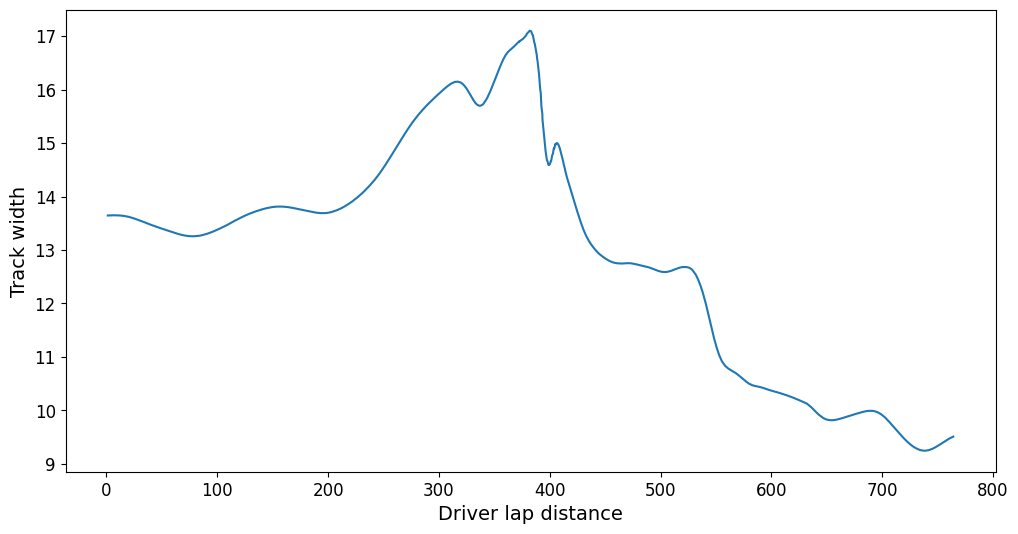

In [7]:
refData = fun.get_track_width_reference_data(DIRECTORY)
plt.xlabel('Driver lap distance')
plt.ylabel('Track width')
plt.plot('LAP_DISTANCE', 'TRACKWIDTH', data=refData)
plt.savefig('../images/trackWidth.png')
plt.show()

In [ ]:
data24 = fun.update_data_w_width(data24, DIRECTORY)
data24 = fun.update_data_w_distances(data24, DIRECTORY)

/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_5831/2288145558.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_5831/2288145558.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agreementTable = pd.concat([newRow, agreementTable])
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_5831/2288145558.py:9: FutureWarning: The provided callable <built-in function max> is

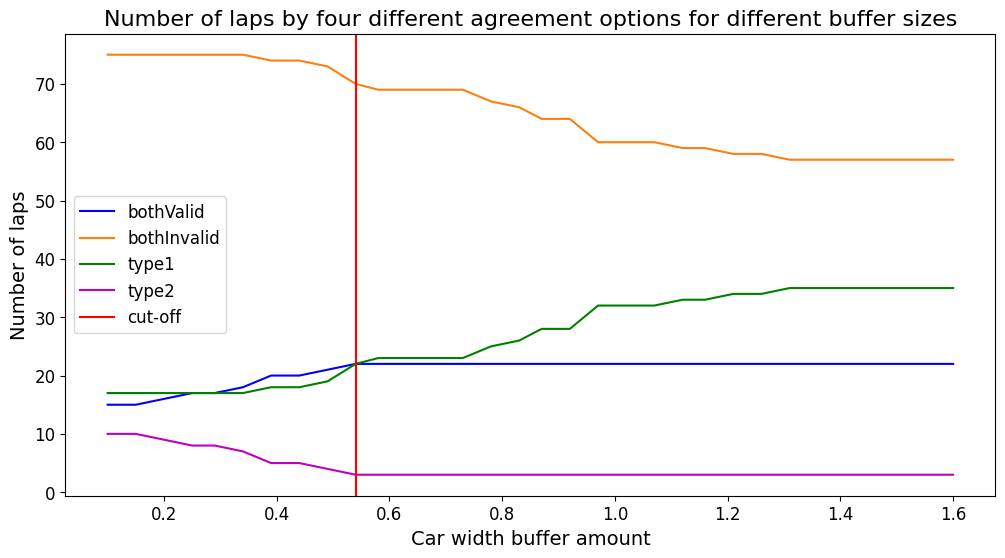

In [12]:
buffers = np.linspace(0.1,1.6, 32)
dfCols = ['buffer', 'bothValid', 'bothInvalid', 'type1', 'type2']
agreementTable = pd.DataFrame(columns=dfCols)

for buffer in buffers.round(2):
    newData24 = data24[['SESSION_IDENTIFIER', 'LAP_NUM', 'WORLDPOSX', 'WORLDPOSY', 'TRACKWIDTH', 'DISTFROMLEFT', 'DISTFROMRIGHT', 'USER_TRACKWIDTH', 'INVALID_LAP']].copy()
    newData24['DIFF'] = newData24['TRACKWIDTH'] + buffer - newData24['USER_TRACKWIDTH']
    newData24['OFF_TRACK'] = np.where(newData24['TRACKWIDTH'] + buffer < newData24['USER_TRACKWIDTH'], 1, 0)
    newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)

    bothValid = newData24[(newData24['MY_INVALID_LAP'] == 0) & (newData24['INVALID_LAP'] == 0)].copy()
    bothInvalid = newData24[(newData24['MY_INVALID_LAP'] == 1) & (newData24['INVALID_LAP'] == 1)].copy()

    # We think valid and they think invalid
    type1disagreement = newData24[(newData24['MY_INVALID_LAP'] == 0) & (newData24['INVALID_LAP'] == 1)].copy()
    # We think invalid and they think valid
    type2disagreement = newData24[(newData24['MY_INVALID_LAP'] == 1) & (newData24['INVALID_LAP'] == 0)].copy()

    newRow = pd.DataFrame([[buffer, 
                            len(bothValid.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])), 
                            len(bothInvalid.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])),
                            len(type1disagreement.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])),
                            len(type2disagreement.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))
                            ]], columns=dfCols
                        )
    agreementTable = pd.concat([newRow, agreementTable])
    
agreementTable = agreementTable.sort_values(by='buffer').reset_index(drop=True)

plt.title('Number of laps by four different agreement options for different buffer sizes')
plt.xlabel('Car width buffer amount')
plt.ylabel('Number of laps')
plt.plot('buffer', 'bothValid', data=agreementTable, c ='b')
plt.plot('buffer', 'bothInvalid', data=agreementTable, c='tab:orange')
plt.plot('buffer', 'type1', data=agreementTable, c='g')
plt.plot('buffer', 'type2', data=agreementTable, c='m')
plt.axvline(x = 0.54, color = 'r', label = 'cut-off')
plt.legend()
plt.savefig('../images/findingBufferSize.png')
plt.show()

## Testing angle to apex

In [5]:
from functions_final_features import get_apex_coords, compute_angle_to_apex

apex1, apex2 = get_apex_coords(DIRECTORY)
data23 = compute_angle_to_apex(data23, apex1, apex2)

In [6]:
## These are laps with null, 4 laps
duds = data23[data23.angle_to_apex1.isna()][['SESSION_IDENTIFIER', 'LAP_NUM']].drop_duplicates().copy()
duds

,SESSION_IDENTIFIER,LAP_NUM


In [7]:
lapsWithNullForward = data23[data23.WORLDFORWARDDIRY.isna()][['SESSION_IDENTIFIER', 'LAP_NUM']].drop_duplicates().copy()
lapsWithNullForward

testDf = pd.DataFrame()

for index, row in duds.iterrows():
    id, lap = row[['SESSION_IDENTIFIER', 'LAP_NUM']]
    pltData = data23[(data23['SESSION_IDENTIFIER'] == id) & (data23['LAP_NUM'] == lap)]
    testDf = pd.concat([testDf, pltData])

testDf

""


In [8]:
testDf = data23.merge(lapsWithNullForward, how='inner', on=['SESSION_IDENTIFIER', 'LAP_NUM'])
testDf
df_cleaned = data23[~data23[['SESSION_IDENTIFIER', 'LAP_NUM']].isin(testDf[['SESSION_IDENTIFIER', 'LAP_NUM']]).all(axis=1)]
# df_cleaned[df_cleaned.WORLDFORWARDDIRX.isna()]
df_cleaned

,SESSION_IDENTIFIER,FRAME,LAP_NUM,SECTOR,LAP_DISTANCE,CURRENT_LAP_TIME_MS,SECTOR_1_TIME_MS,SECTOR_2_TIME_MS,LAP_TIME_MS,SECTOR_3_MS,...,WORLDPOSY,WORLDPOSZ,WORLDFORWARDDIRX,WORLDFORWARDDIRY,WORLDFORWARDDIRZ,WORLDRIGHTDIRX,WORLDRIGHTDIRY,WORLDRIGHTDIRZ,angle_to_apex1,angle_to_apex2
0,1.003468e+19,1680,1,0,1.775714,16,30129,18569,87226.0,38528.0,...,465.303589,2.900799,-23615.0,-138.0,-22714.0,22704.0,846.0,-23610.0,133.446400,123.936313
1,1.003468e+19,1681,1,0,5.864580,66,30129,18569,87226.0,38528.0,...,462.470612,2.874730,-23685.0,-190.0,-22641.0,22630.0,850.0,-23681.0,133.295631,123.704226
2,1.003468e+19,1682,1,0,9.964501,116,30129,18569,87226.0,38528.0,...,459.637115,2.845881,-23765.0,-195.0,-22557.0,22547.0,812.0,-23761.0,133.256963,123.582948
3,1.003468e+19,1683,1,0,14.072903,166,30129,18569,87226.0,38528.0,...,456.805298,2.821898,-23824.0,-174.0,-22495.0,22485.0,809.0,-23820.0,133.278129,123.520257
4,1.003468e+19,1684,1,0,18.184681,216,30129,18569,87226.0,38528.0,...,453.976288,2.798889,-23838.0,-140.0,-22480.0,22471.0,820.0,-23833.0,133.327735,123.484745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132439,9.922656e+18,3705,2,0,749.205078,13580,36499,22353,102385.0,43533.0,...,-97.190880,3.249786,-22431.0,-39.0,-23884.0,23882.0,-489.0,-22428.0,-61.474946,-48.841132
1132440,9.922656e+18,3707,2,0,755.364746,13680,36499,22353,102385.0,43533.0,...,-101.683434,3.236460,-22265.0,-63.0,-24039.0,24037.0,-498.0,-22262.0,-61.274681,-48.859662
1132441,9.922656e+18,3708,2,0,758.476074,13730,36499,22353,102385.0,43533.0,...,-103.963165,3.228930,-22179.0,-78.0,-24118.0,24116.0,-506.0,-22176.0,-61.187556,-48.881224
1132442,9.922656e+18,3709,2,0,761.607910,13780,36499,22353,102385.0,43533.0,...,-106.265083,3.220151,-22095.0,-79.0,-24196.0,24194.0,-503.0,-22091.0,-61.067624,-48.869459


In [9]:
badRowsRemoved = data23[data23.WORLDFORWARDDIRX.notna()]

for index, row in duds.iterrows():
    id, lap = row[['SESSION_IDENTIFIER', 'LAP_NUM']]
    print('id:', id, len(badRowsRemoved[(badRowsRemoved['SESSION_IDENTIFIER'] == id) & (badRowsRemoved['LAP_NUM'] == lap)]))
    # pltData = mergedData[(mergedData['SESSION_IDENTIFIER'] == id) & (mergedData['LAP_NUM'] == lap)]
    # pltData = pltData[pltData.WORLDFORWARDDIRX.notna()]
    # print(pltData['CURRENT_LAP_TIME_MS'].max())
    # plt.scatter(data=pltData, x='WORLDPOSX', y='WORLDPOSY', s=1)
    # plt.scatter(data=track, x='WORLDPOSX', y='WORLDPOSY', s=0.1, c='b')
    # plt.show()

## Looking into gear and rpm

In [10]:
'''
Split data into quick and slow laps
'''

include_cols = [
        'SESSION_GUID',
        'M_CURRENTLAPNUM',
        'M_CURRENTLAPTIMEINMS_1',
        'M_LAPTIMEINMS',
        'M_LAPDISTANCE_1',
        'M_WORLDPOSITIONX_1',
        'M_WORLDPOSITIONY_1',
        'M_SPEED_1',
        'M_THROTTLE_1',
        'M_STEER_1',
        'M_BRAKE_1',
        'M_GEAR_1',
        'M_ENGINERPM_1'
    ]

wholeData24 = pd.read_csv(DIRECTORY + '/F124 Data Export UNSW csv.csv')
wholeData24 = wholeData24[include_cols]
wholeData24 = wholeData24.rename(columns={
'SESSION_GUID': 'SESSION_IDENTIFIER',
'M_CURRENTLAPNUM': 'LAP_NUM',
'M_CURRENTLAPTIMEINMS_1': 'CURRENT_LAP_TIME_MS',
'M_LAPTIMEINMS': 'LAP_TIME_MS',
'M_LAPDISTANCE_1': 'LAP_DISTANCE',
'M_WORLDPOSITIONX_1': 'WORLDPOSX',
'M_WORLDPOSITIONY_1': 'WORLDPOSY',
'M_SPEED_1': 'SPEED_KPH',
'M_THROTTLE_1': 'THROTTLE',
'M_STEER_1': 'STEERING',
'M_BRAKE_1': 'BRAKE',
'M_GEAR_1': 'GEAR',
'M_ENGINERPM_1': 'RPM'
})

QUICK_THRESHOLD = 81000
SLOW_THRESHOLD = 140000

testData24 = wholeData24[['SESSION_IDENTIFIER', 'LAP_NUM', 'LAP_TIME_MS']].drop_duplicates()
testData24['QUICK'] = np.where(testData24['LAP_TIME_MS'] < QUICK_THRESHOLD, 1, 0)

# print(testData24.head(5))
testData24[['QUICK', 'LAP_TIME_MS']].groupby('QUICK').describe()

quickData24, slowData24 = [x for _, x in wholeData24.groupby(wholeData24['LAP_TIME_MS'] >= QUICK_THRESHOLD)]
slowData24, verySlowData24 = [x for _, x in slowData24.groupby(slowData24['LAP_TIME_MS'] >= SLOW_THRESHOLD)]
 
print(slowData24.head(5))

/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2173902407.py:21: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  wholeData24 = pd.read_csv(DIRECTORY + '/F124 Data Export UNSW csv.csv')


                 SESSION_IDENTIFIER  LAP_NUM  CURRENT_LAP_TIME_MS  \
0  1BF21BECE1C29DBFE0631718000AACA5        1                 1007   
1  1BF21BECE1C29DBFE0631718000AACA5        1                 1018   
2  1BF21BECE1C29DBFE0631718000AACA5        1                 1027   
3  1BF21BECE1C29DBFE0631718000AACA5        1                 1036   
4  1BF21BECE1C29DBFE0631718000AACA5        1                 1045   

   LAP_TIME_MS  LAP_DISTANCE   WORLDPOSX   WORLDPOSY  SPEED_KPH  THROTTLE  \
0        84622            82  171.782469  410.474624      299.0       1.0   
1        84622            83  172.501417  409.780637      299.0       1.0   
2        84622            84  173.220438  409.086688      299.0       1.0   
3        84622            85  173.939458  408.392739      299.0       1.0   
4        84622            86  174.658479  407.698789      299.0       1.0   

   STEERING  BRAKE  GEAR      RPM  
0       0.0    0.0   8.0  10656.0  
1       0.0    0.0   8.0  10658.0  
2       0.0   

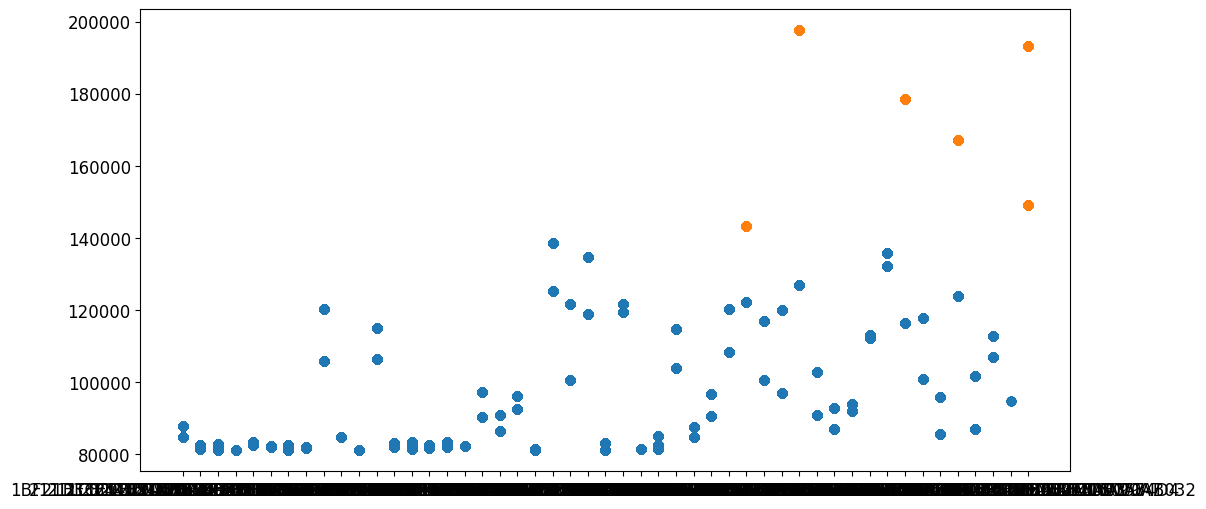

In [11]:
plt.scatter(x='SESSION_IDENTIFIER', y='LAP_TIME_MS', data=slowData24)
plt.scatter(x='SESSION_IDENTIFIER', y='LAP_TIME_MS', data=verySlowData24)
plt.show()

/Users/tom/.pyenv/versions/3.10.1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


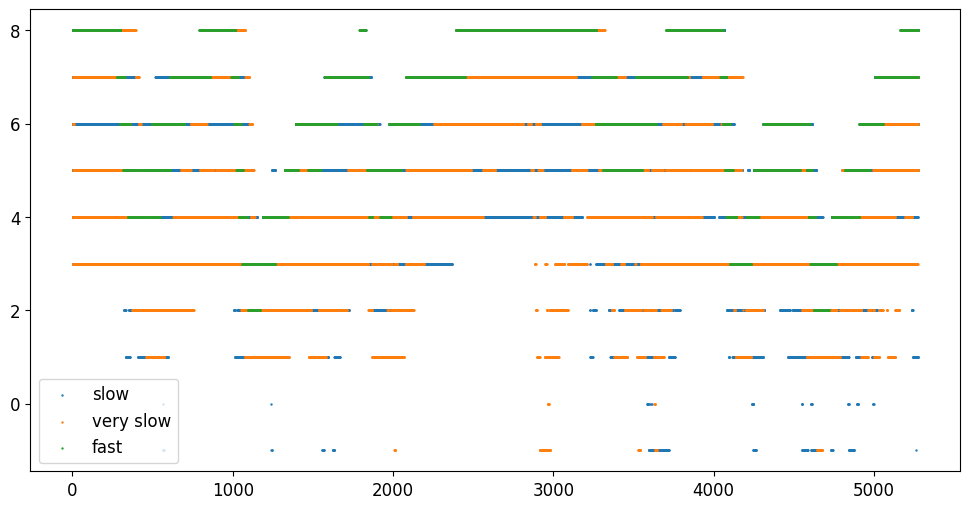

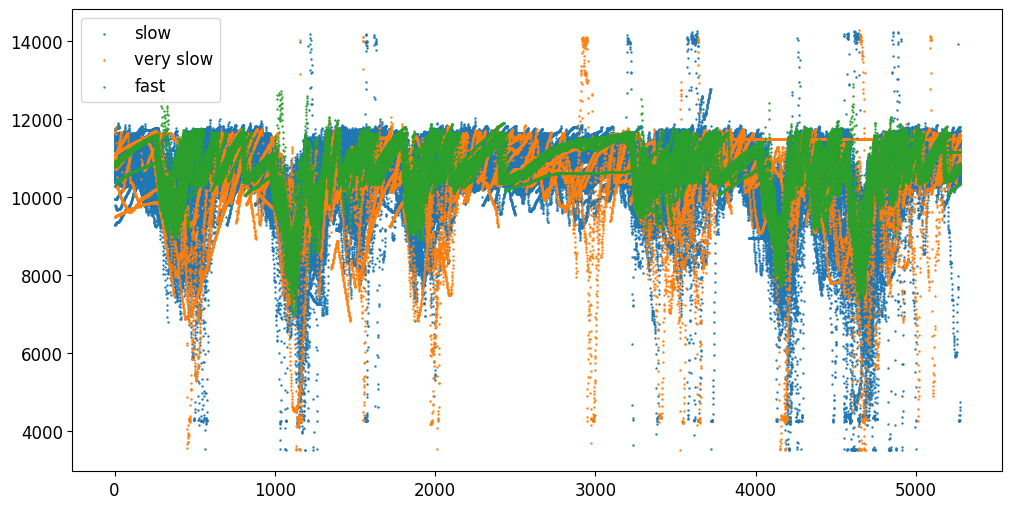

In [12]:
'''
Plot gear and rpm for quick and slow laps
'''

plt.scatter(x='LAP_DISTANCE', y='GEAR', data=slowData24, s=0.5, label='slow')
plt.scatter(x='LAP_DISTANCE', y='GEAR', data=verySlowData24, s=0.5, label='very slow')
plt.scatter(x='LAP_DISTANCE', y='GEAR', data=quickData24, s=0.5, label='fast')
plt.legend()
plt.show()
plt.scatter(x='LAP_DISTANCE', y='RPM', data=slowData24, s=0.5, label='slow')
plt.scatter(x='LAP_DISTANCE', y='RPM', data=verySlowData24, s=0.5, label='very slow')
plt.scatter(x='LAP_DISTANCE', y='RPM', data=quickData24, s=0.5, label='fast')
plt.legend()
plt.show()

       CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
13246                95301   0.0 -168.415222  725.665294
13247                95353   0.0 -167.596553  725.072826
13248                95408   0.0 -166.773927  724.484506
13249                95468   0.0 -165.946034  723.901599
13250                95532   0.0 -165.114689  723.321934
13326                95601   0.0 -164.279375  722.746937
13327                95678   0.0 -163.436936  722.178530
13328                95768   0.0 -162.588501  721.616255
28066                22393   0.0  617.143275 -434.438815
28067                23190  -1.0  616.351338 -435.013985
28138                23544  -1.0  615.572128 -435.588903
28139                23821  -1.0  614.806494 -436.164323


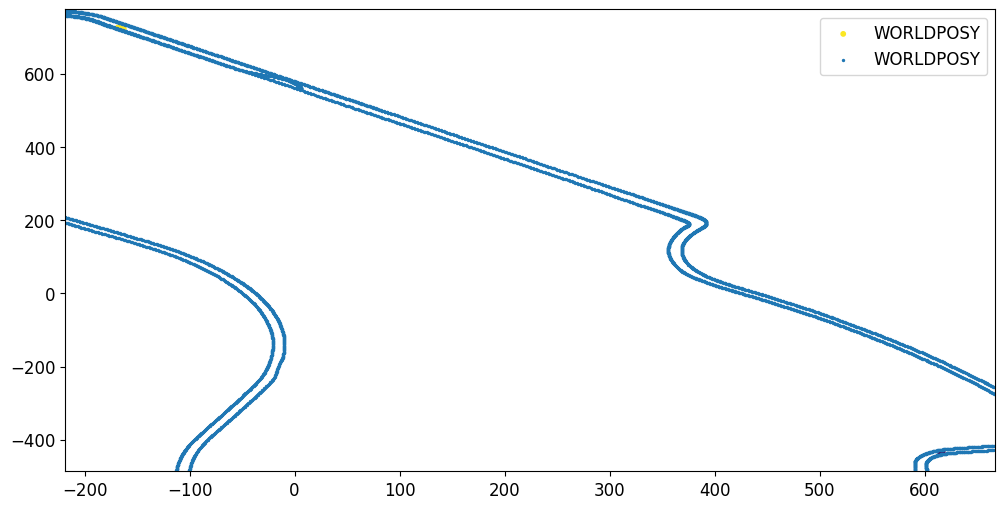

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
36910                 95169  -1.0 -200.625957  767.529711
36911                 95297  -1.0 -199.573353  767.171942
36912                 95420  -1.0 -198.528092  766.754500
36913                 95539  -1.0 -197.511817  766.262799
36914                 95654  -1.0 -196.511629  765.731371
...                     ...   ...         ...         ...
103584                64823   0.0 -653.940578  832.511080
273656               109727   0.0  -97.104533  655.590298
273657               109825   0.0  -96.482862  654.795839
273658               109948   0.0  -95.865270  653.997550
273734               110104   0.0  -95.198262  653.249578

[64 rows x 4 columns]


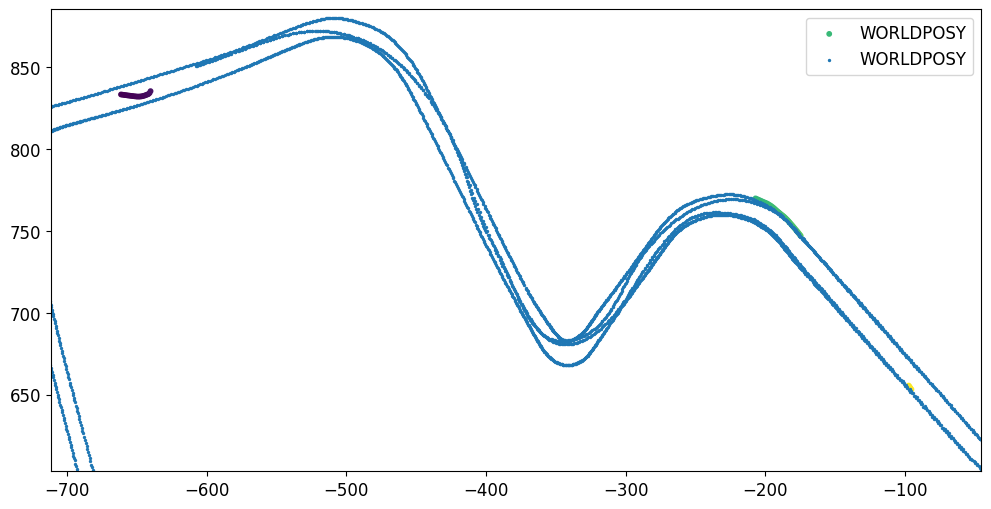

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
82887                 35664  -1.0  531.833639 -717.809522
82888                 36121  -1.0  531.833639 -717.809522
189562               116804  -1.0  105.028090  474.681401
597107                82943   0.0 -651.661009  827.599294
597108                88132  -1.0 -650.820219  832.417016


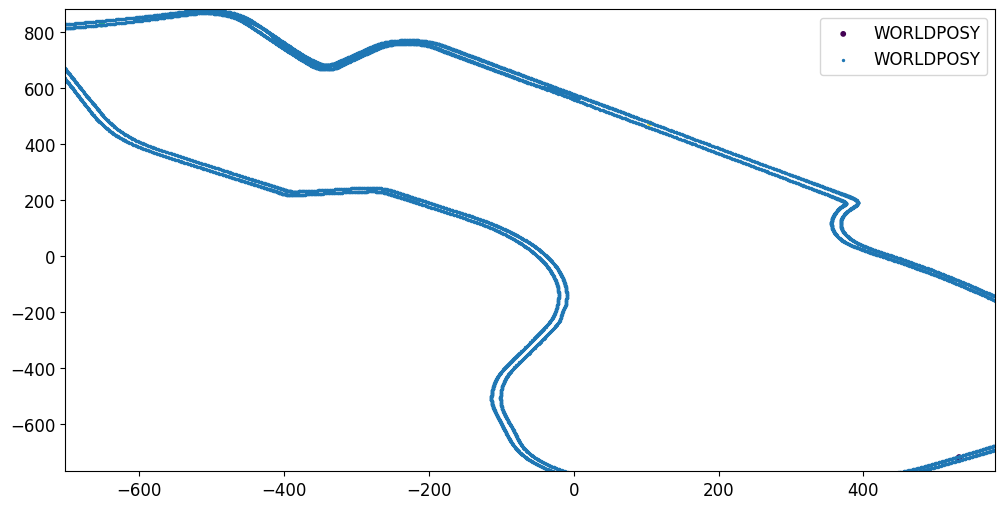

        CURRENT_LAP_TIME_MS  GEAR  WORLDPOSX  WORLDPOSY
91598                 76272  -1.0 -35.885229 -41.270012
91599                 76335  -1.0 -35.885229 -41.270012
91600                 76388  -1.0 -35.885229 -41.270012
91601                 76440  -1.0 -36.606172 -38.414892
91602                 76492  -1.0 -36.606172 -38.414892
91630                 77054  -1.0 -37.896493 -27.464673
91631                 77109  -1.0 -37.770993 -26.381479
91632                 77202  -1.0 -37.561048 -25.267339
91633                 77291  -1.0 -37.561048 -25.267339
91673                 76533  -1.0 -36.606172 -38.414892
91674                 76589  -1.0 -36.606172 -38.414892
91675                 76646  -1.0 -37.397630 -34.551434
91676                 76699  -1.0 -37.561559 -33.567554
91705                 77392  -1.0 -36.707119 -22.879223
91706                 77526  -1.0 -36.707119 -22.879223
91745                 76741  -1.0 -37.701629 -32.580334
91746                 76793  -1.0 -37.701629 -32

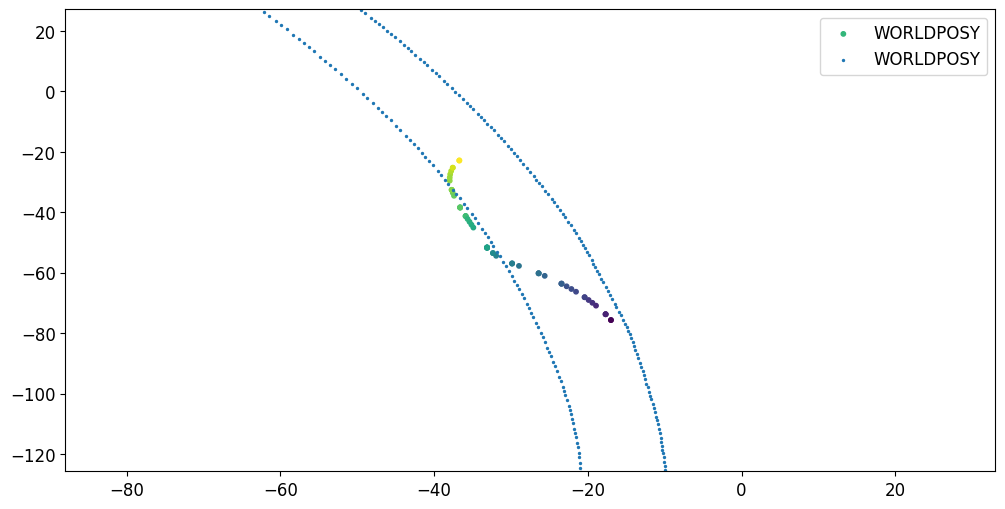

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
107204                11055   0.0  396.608908   29.174212
107205                13140  -1.0  398.407009   25.252267
107206                13520  -1.0  398.407009   25.252267
107276                13904  -1.0  398.407009   25.252267
307659                97558  -1.0 -398.628738  752.693319
307660                97820  -1.0 -398.628738  752.693319
307726                98033  -1.0 -398.628738  752.693319
307727                98240  -1.0 -397.527258  749.865956
307728                98433  -1.0 -396.979684  749.027640
307729                98599  -1.0 -396.341554  748.242224
307800                98780  -1.0 -396.341554  748.242224
307801                98961  -1.0 -396.341554  748.242224
307802                99130  -1.0 -396.341554  748.242224
307803                99302  -1.0 -392.705085  745.726625
307804                99515  -1.0 -392.705085  745.726625
307871                99724  -1.0 -392.705085  745.726625
307872        

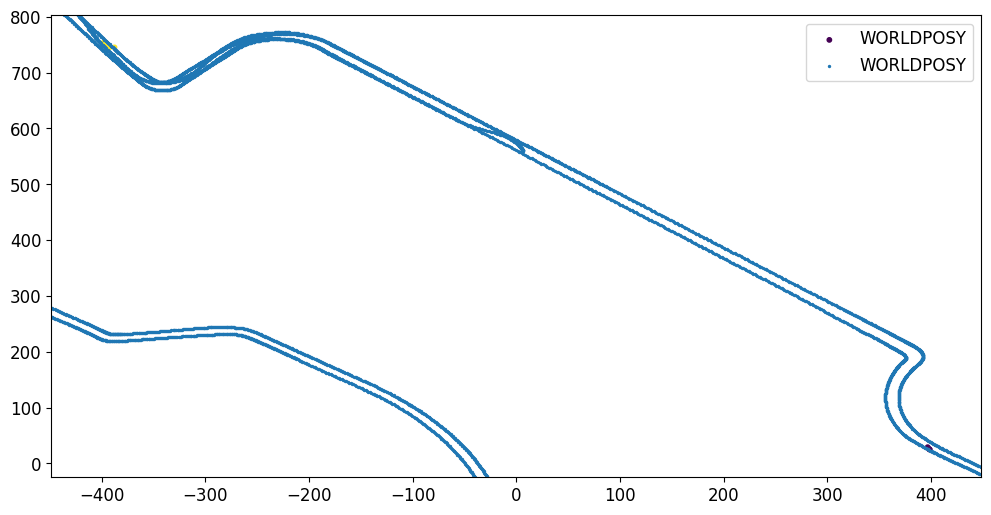

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
117589                89479  -1.0 -392.413518  740.127709
311378                84587  -1.0 -398.105606  742.598846
614083                88100  -1.0 -398.105606  742.598846
614084                88441  -1.0 -396.223751  741.374318
614085                88706  -1.0 -396.223751  741.374318
614086                88967  -1.0 -393.900410  740.412003
614087                89200  -1.0 -392.413518  740.127709


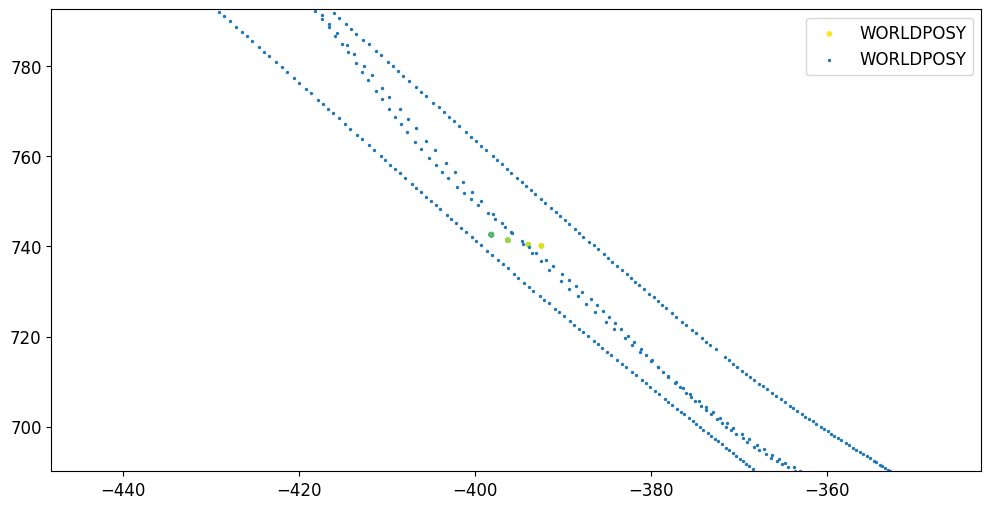

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
125364                74926  -1.0 -582.889351  389.389485
125365                74971  -1.0 -582.889351  389.389485
125366                75018  -1.0 -590.971517  392.376670
125367                75066  -1.0 -592.082794  392.674501
125368                75116  -1.0 -593.224210  392.949887
...                     ...   ...         ...         ...
351969                73073  -1.0 -553.364470  368.913137
455513                71300  -1.0 -526.923367  339.830328
455514                71350  -1.0 -527.691636  340.470238
455515                71399  -1.0 -528.450035  341.121596
455516                71447  -1.0 -529.197789  341.786279

[120 rows x 4 columns]


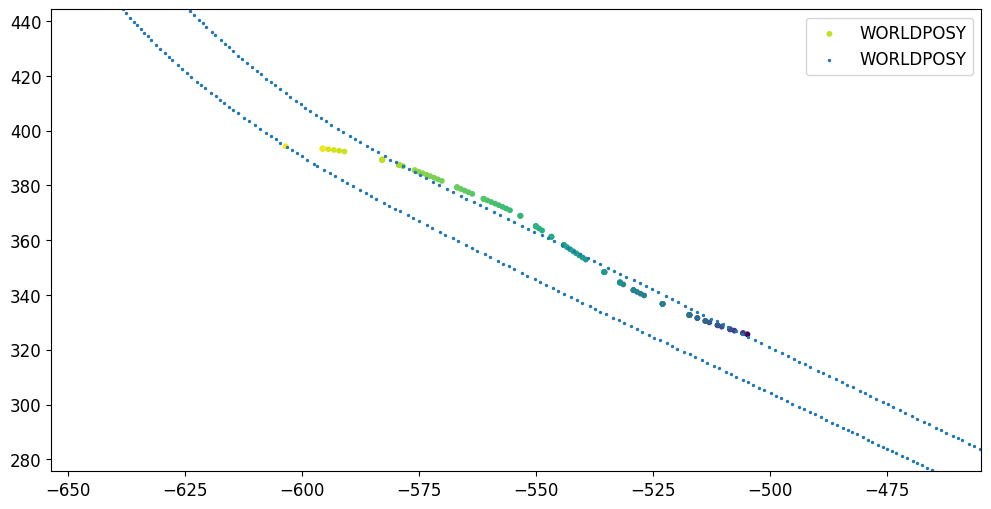

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
128964                83344  -1.0 -412.450564  765.511274
129033                83705  -1.0 -410.676473  764.221713
129034                84011  -1.0 -408.968582  764.048650
129035                84374  -1.0 -408.968582  764.048650


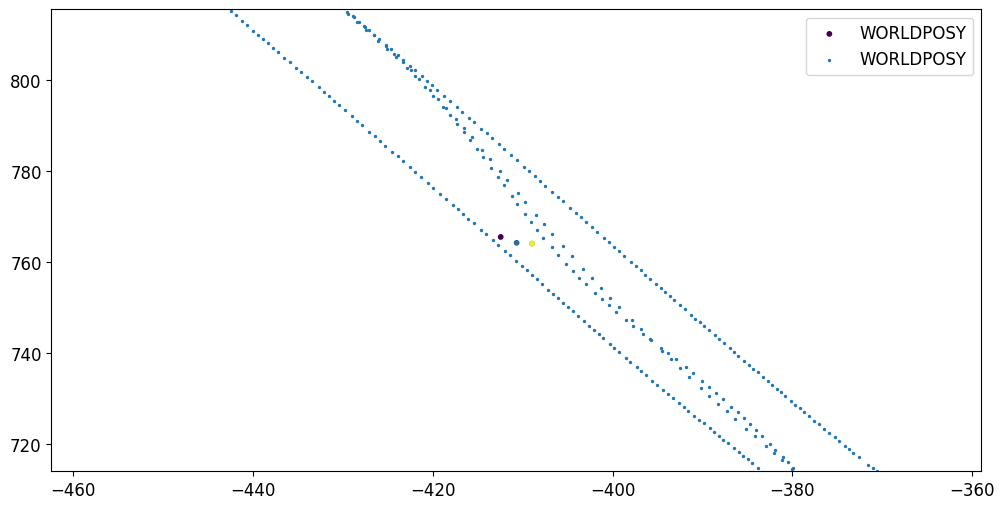

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
131986                43013  -1.0  539.846257 -708.519001
132062                43480  -1.0  538.137100 -712.882311
132063                43815  -1.0  537.963610 -714.307370
132064                44119  -1.0  537.963610 -714.307370
132065                44517  -1.0  538.693050 -718.575034


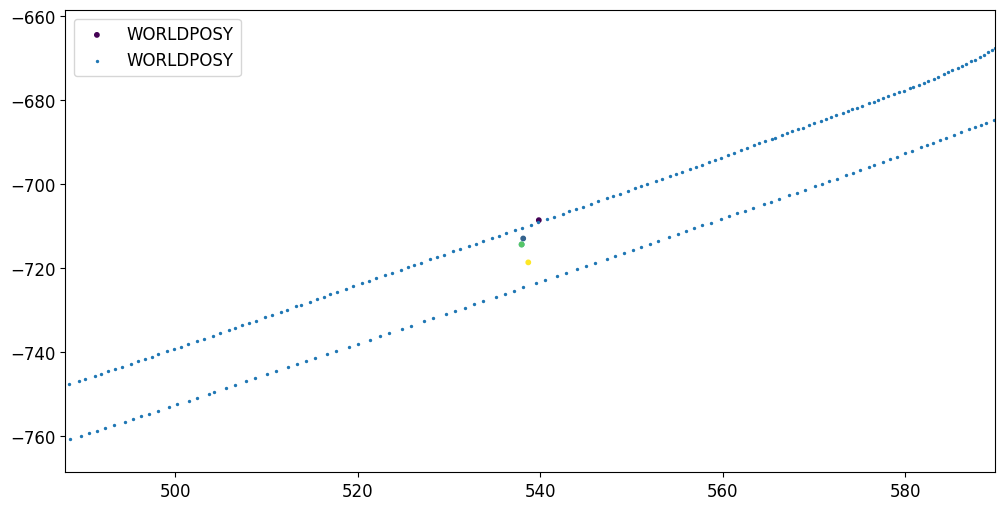

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
188631                75615  -1.0 -371.514575  707.282417
485997                73581   0.0 -383.320953  717.447805
486069                73674   0.0 -382.667986  716.672183
486070                73789   0.0 -382.667986  716.672183
486071                73924   0.0 -382.667986  716.672183
486072                74028   0.0 -382.667986  716.672183
486073                74156   0.0 -382.667986  716.672183
486141                74276  -1.0 -379.176207  712.956047
486142                74406  -1.0 -378.408959  712.261921
486143                74529  -1.0 -377.615598  711.586693
486144                74660  -1.0 -377.615598  711.586693
486214                74792  -1.0 -375.964364  710.285137
486215                74927  -1.0 -375.127328  709.644386
486216                75069  -1.0 -375.127328  709.644386
486217                75218  -1.0 -373.376215  708.421212
486218                75405  -1.0 -373.376215  708.421212


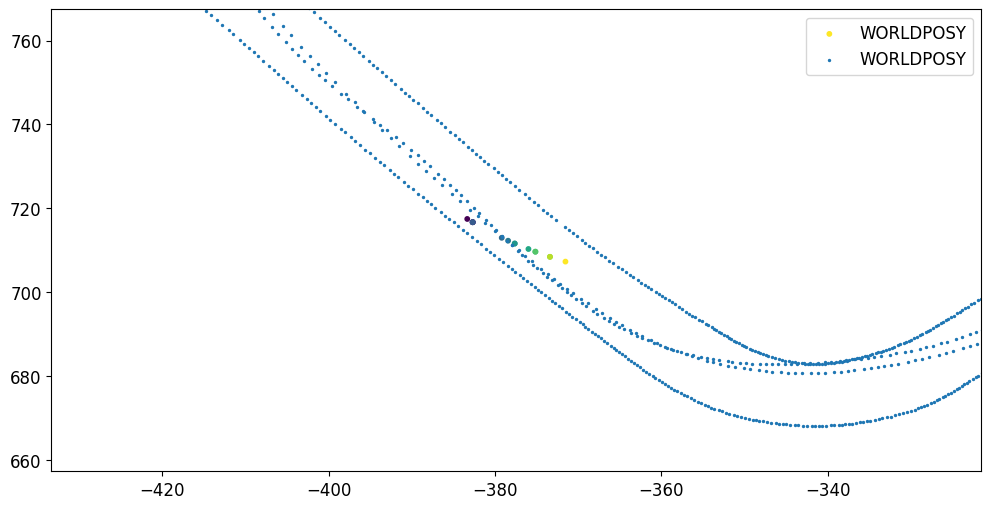

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
193729               122385  -1.0 -343.472236  685.489100
193730               122425  -1.0 -342.992724  685.292612
193731               122465  -1.0 -342.511336  685.092074
193732               122504  -1.0 -342.028128  684.886539
193803               122544  -1.0 -341.536420  684.671952
193804               122587  -1.0 -341.012991  684.435910
193805               122616  -1.0 -340.471922  684.182747
193806               122657  -1.0 -340.471922  684.182747
193807               122708  -1.0 -340.471922  684.182747
193876               122758  -1.0 -340.471922  684.182747
193877               122800  -1.0 -338.333775  683.128777
193878               122859  -1.0 -337.449766  682.612459
193879               122959  -1.0 -337.449766  682.612459
193951               123092  -1.0 -337.449766  682.612459
193952               124042  -1.0 -337.449766  682.612459
308105                83137  -1.0 -453.560059  273.280265
308106        

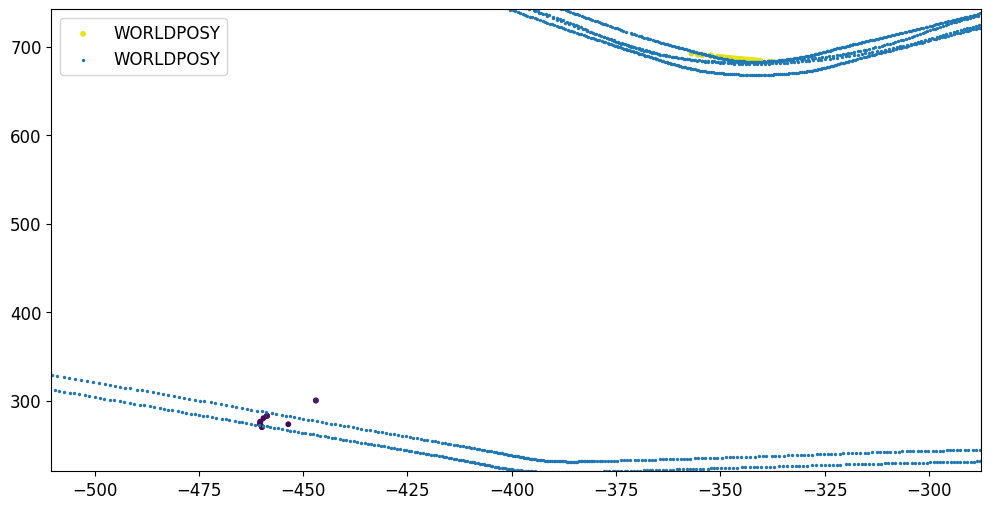

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
198741                36121  -1.0  478.443448 -754.430187
456011                96989  -1.0 -394.378239  735.466124
577148                34096  -1.0  494.738007 -756.797607
577219                34545  -1.0  494.738007 -756.797607
577220                34782  -1.0  490.098069 -757.284265
577221                34970  -1.0  488.866201 -757.290437
577222                35151  -1.0  488.866201 -757.290437
577293                35308  -1.0  488.866201 -757.290437
577294                35460  -1.0  484.867919 -756.823531
577295                35611  -1.0  484.867919 -756.823531
577296                35749  -1.0  484.867919 -756.823531
577297                35916  -1.0  484.867919 -756.823531


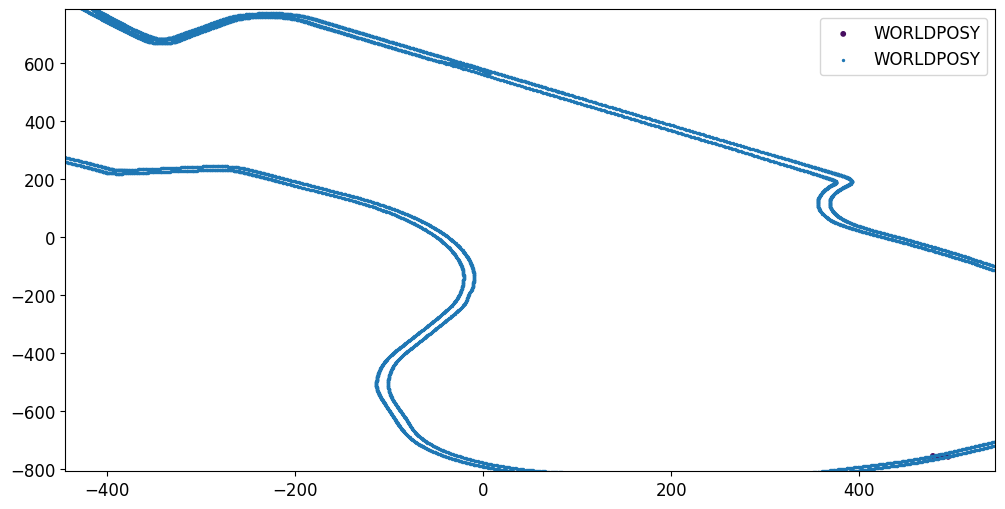

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
259268                92923  -1.0 -377.269962  720.214856
259269                93237  -1.0 -377.269962  720.214856
259270                93456  -1.0 -377.269962  720.214856
259271                93621  -1.0 -374.011723  717.609878
428947                93756  -1.0 -374.011723  717.609878
428948                93902  -1.0 -372.531779  716.216622
428949                94009  -1.0 -371.857886  715.477176
428950                94122  -1.0 -371.857886  715.477176
428951                94236  -1.0 -370.615468  713.929048
429020                94347  -1.0 -370.040797  713.123972
429021                94447  -1.0 -370.040797  713.123972
429022                94530  -1.0 -370.040797  713.123972
429023                94631  -1.0 -368.498369  710.584291
429024                94724  -1.0 -368.044162  709.695804
429097                94802  -1.0 -367.619473  708.786438
429098                94887  -1.0 -367.229770  707.851909
429099        

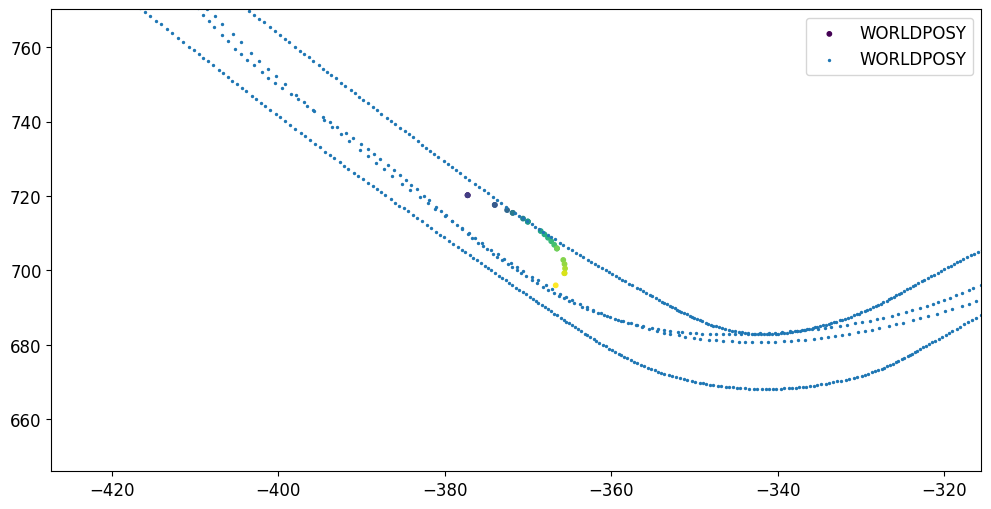

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
281090               122944  -1.0 -544.833306  343.535859
281091               123104  -1.0 -544.833306  343.535859
281092               123271  -1.0 -544.833306  343.535859
281093               123474  -1.0 -543.475685  349.717588
281094               123786  -1.0 -541.335505  353.744693
321608               102613   0.0  -37.002214  -27.166179
321609               102671   0.0  -37.153062  -26.173883
321610               102729   0.0  -37.275270  -25.170082
321611               102786   0.0  -37.368919  -24.155983
597538               102836   0.0  -37.449929  -23.135999
597539               102919   0.0  -37.515062  -22.109248
597540               102995   0.0  -37.558276  -21.073094
597541               103075  -1.0  -37.580563  -20.028411
597578               122145  -1.0 -544.210625  336.543298
597579               122304  -1.0 -544.513197  337.732586
597580               122487  -1.0 -544.513197  337.732586
597581        

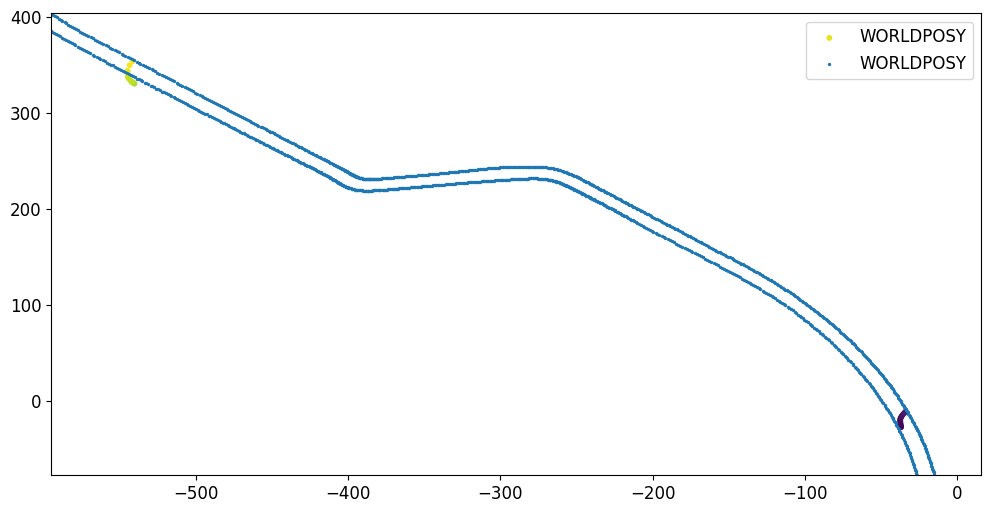

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
283934                61528   0.0 -512.125913  332.502587
283935                61676   0.0 -513.918458  333.486111
283936                62407  -1.0 -515.087576  333.658176


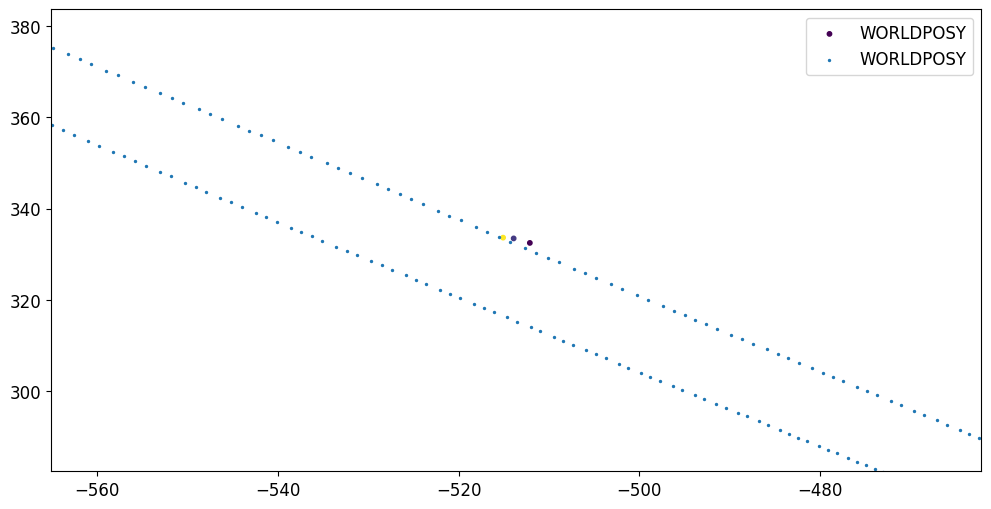

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
413923                69170  -1.0 -641.089762  842.791035
413995                69927  -1.0 -638.547926  840.912293
413996                70352  -1.0 -636.869337  838.397778


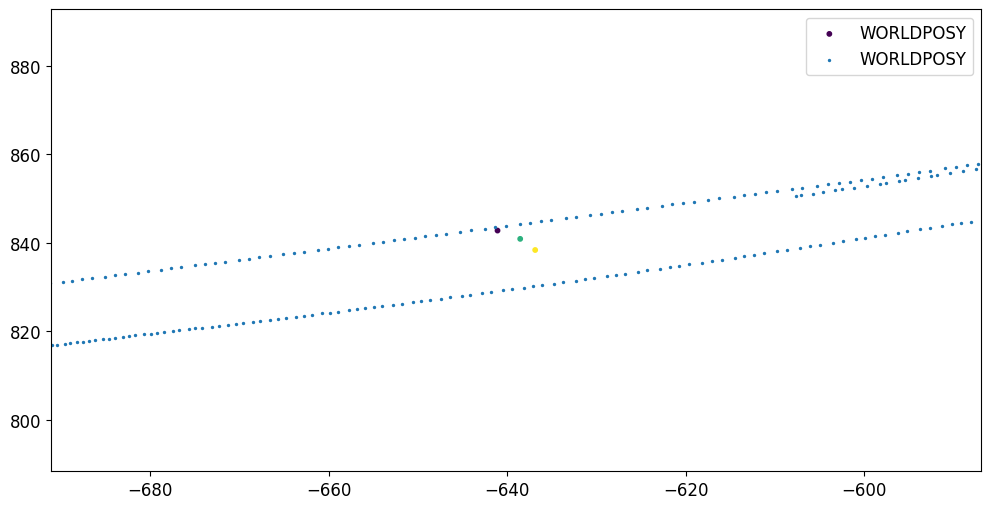

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
417375                81968  -1.0 -380.039451  709.949436
417376                82322  -1.0 -378.735055  709.615391
417377                82546  -1.0 -377.562258  709.196278
417446                82716  -1.0 -376.479735  708.718801
417447                82849  -1.0 -376.479735  708.718801
417448                82978  -1.0 -376.479735  708.718801
417449                83093  -1.0 -376.479735  708.718801
617025                84006  -1.0 -366.339114  698.735798
617026                84070  -1.0 -366.339114  698.735798
617027                84136  -1.0 -365.395426  696.955874
617028                84215  -1.0 -364.962249  696.032977
617029                84266  -1.0 -364.555981  695.084578
617098                84331  -1.0 -364.180504  694.109240
617099                84395  -1.0 -363.833099  693.106545
617100                84474  -1.0 -363.515509  692.076029
617101                84523  -1.0 -363.515509  692.076029
617102        

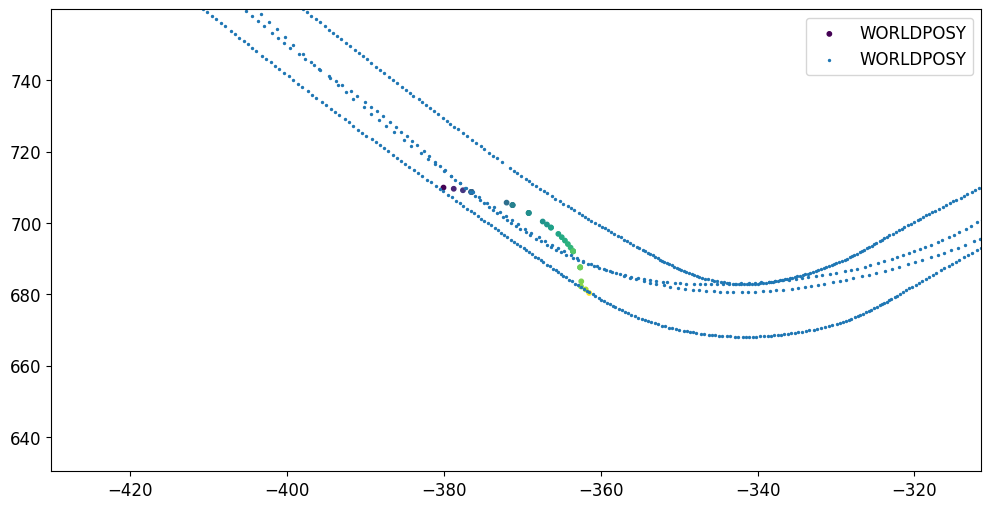

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
477080                93309  -1.0 -299.644058  716.229567
477081                93726  -1.0 -299.644058  716.229567
477082                93995  -1.0 -297.285611  720.796871
477083                94215  -1.0 -296.420691  721.367814
477151                94398  -1.0 -295.505145  721.896455
477152                94582  -1.0 -294.523363  722.368142
477153                94755  -1.0 -294.523363  722.368142
477154                94912  -1.0 -292.308051  723.102259
477223                95102  -1.0 -291.034568  723.329884
477224                95268  -1.0 -291.034568  723.329884
477225                95484  -1.0 -287.910230  723.303838
477226                95729  -1.0 -285.779235  722.781782


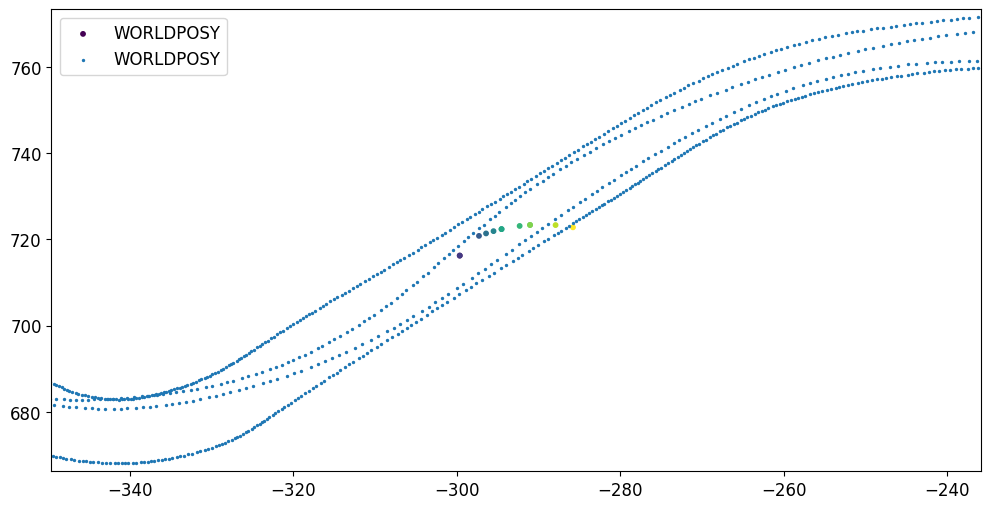

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
432758                90026   0.0 -414.378469  767.866144
432759                90114   0.0 -414.378469  767.866144
432760                90216   0.0 -412.716994  765.358180
432761                90341   0.0 -412.716994  765.358180
492473                90519  -1.0 -411.609880  763.686379


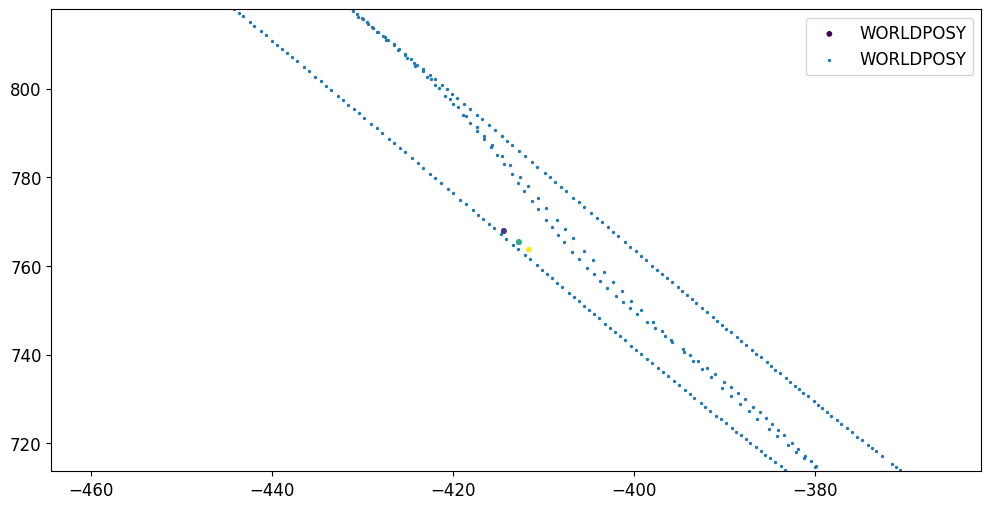

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
509689                65813  -1.0 -531.567368  337.494130
509690                65879  -1.0 -532.210884  338.279374
509691                65927  -1.0 -532.830988  339.092140
509692                65975  -1.0 -532.830988  339.092140
509693                66023  -1.0 -532.830988  339.092140
...                     ...   ...         ...         ...
625073                65565  -1.0 -526.531203  332.615010
625146                65615  -1.0 -526.531203  332.615010
625147                65666  -1.0 -526.531203  332.615010
625148                65715  -1.0 -530.224135  335.988782
625149                65765  -1.0 -530.905674  336.729778

[84 rows x 4 columns]


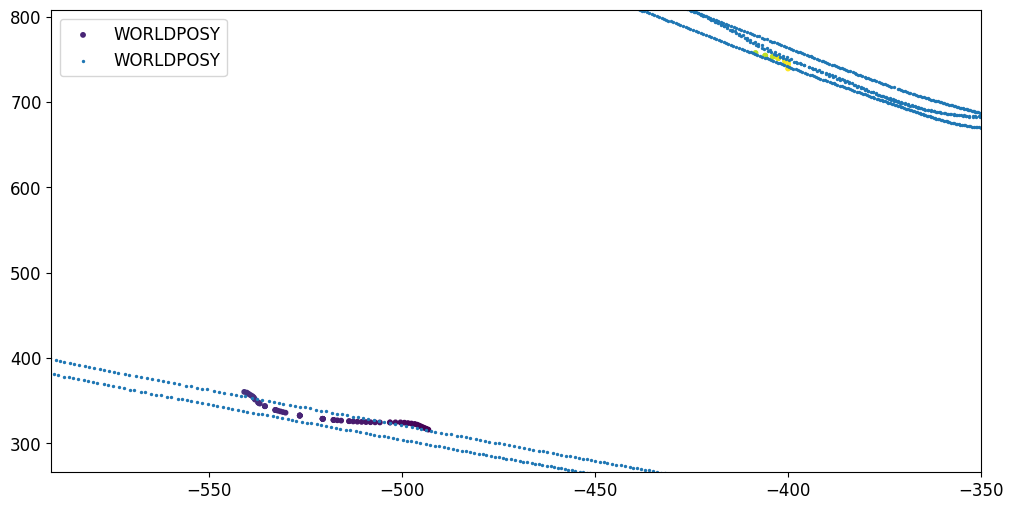

        CURRENT_LAP_TIME_MS  GEAR   WORLDPOSX   WORLDPOSY
587086                64102  -1.0  146.197362 -820.636901
587150                64464  -1.0  146.197362 -820.636901
587151                64677  -1.0  146.197362 -820.636901
587152                64853  -1.0  146.197362 -820.636901
587153                65015  -1.0  146.197362 -820.636901
587226                65208  -1.0  137.562941 -829.318790


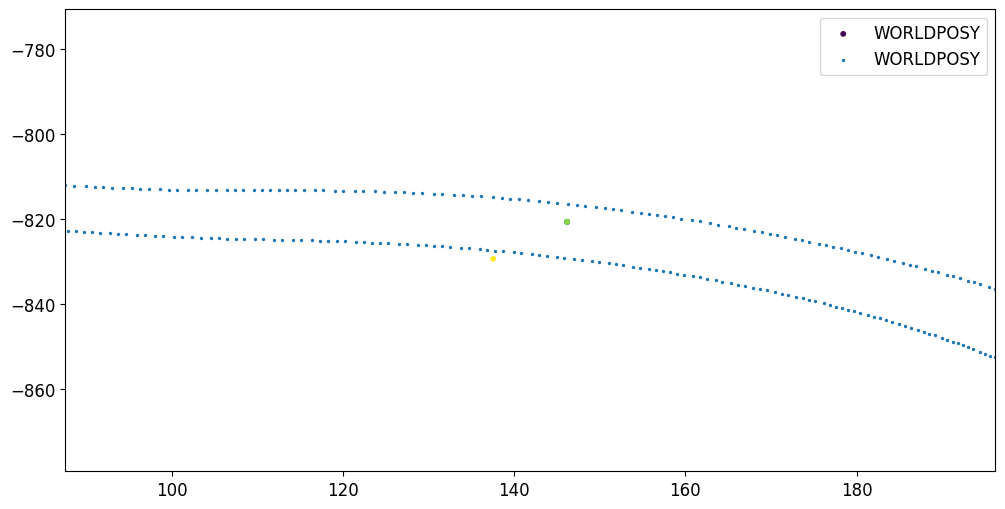

In [13]:
neg1GearLaps = wholeData24[wholeData24['GEAR'] == -1][['SESSION_IDENTIFIER', 'LAP_NUM']].drop_duplicates()
for index, row in neg1GearLaps.iterrows():
    pltData = wholeData24[(wholeData24['SESSION_IDENTIFIER'] == row['SESSION_IDENTIFIER']) & (wholeData24['LAP_NUM'] == row['LAP_NUM'])]
    pltData = pltData[pltData['GEAR'] <= 0]
    xLowLim = pltData['WORLDPOSX'].min() - 50
    xUpLim = pltData['WORLDPOSX'].max() + 50
    yLowLim = pltData['WORLDPOSY'].min() - 50
    yUpLim = pltData['WORLDPOSY'].max() + 50
    print(pltData[['CURRENT_LAP_TIME_MS', 'GEAR', 'WORLDPOSX', 'WORLDPOSY']])
    plt.xlim((xLowLim, xUpLim))
    plt.ylim((yLowLim, yUpLim))
    plt.scatter(data=pltData, x='WORLDPOSX', y='WORLDPOSY', c='CURRENT_LAP_TIME_MS', s=10)
    plt.scatter(data=wholeTrack, x='WORLDPOSX', y='WORLDPOSY', s=2)
    plt.legend()
    plt.show()

In [14]:
# data24 = pd.read_csv(DIRECTORY + '/F124 Data Export UNSW csv.csv')
verstappen = data24[data24['SESSION_GUID'].isna()]

# for col in verstappen.columns:
    # if 'RPM' in col:
    # print(col)

print(verstappen.head(5)[['M_LAPDISTANCE_1', 'M_GEAR_1']])

plt.scatter(x='M_LAPDISTANCE_1', y='M_GEAR_1', data=verstappen)
plt.show()
plt.scatter(x='M_LAPDISTANCE_1', y='M_ENGINERPM_1', data=verstappen)
plt.show()

gear = data24['M_GEAR_1'].copy()
# gear.describe()
len(gear[gear < 0])

print(verstappen['M_CURRENTLAPTIMEINMS_1'].max())

# print(verstappen.columns)

KeyError: 'SESSION_GUID'

## Creating lap flag

In [76]:
data24 = fun.create_invalid_lap_flag(data24, track, DIRECTORY)

lapsCount = len(data24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))
print(lapsCount)

goodLaps = data24[data24['INVALID_LAP'] == 0].copy()
badLaps = data24[data24['INVALID_LAP'] == 1].copy()

goodLapsCount = len(goodLaps.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))
badLapsCount = len(badLaps.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))

print(f'There are {goodLapsCount} valid laps and {badLapsCount} invalid laps in the 2024 data, as defined by us')

groupedData24 = data24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])[['SESSION_IDENTIFIER', 'LAP_NUM']]
data24keys = list(groupedData24.groups.keys())
groupedGoodLaps = goodLaps.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])[['SESSION_IDENTIFIER', 'LAP_NUM']]
goodLapsKeys = list(groupedGoodLaps.groups.keys())
groupedBadLaps = badLaps.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])[['SESSION_IDENTIFIER', 'LAP_NUM']]
badLapsKeys = list(groupedBadLaps.groups.keys())

assert len(goodLapsKeys) < len(data24keys)
for key in goodLapsKeys:
    data24keys.remove(key)
for key in badLapsKeys:
    data24keys.remove(key)
print(data24keys)

117
There are 43 valid laps and 73 invalid laps in the 2024 data, as defined by us
[(nan, 1)]


In [81]:
funnyLap = data24[data24['SESSION_IDENTIFIER'].isna()].sort_values(by='LAP_DISTANCE')

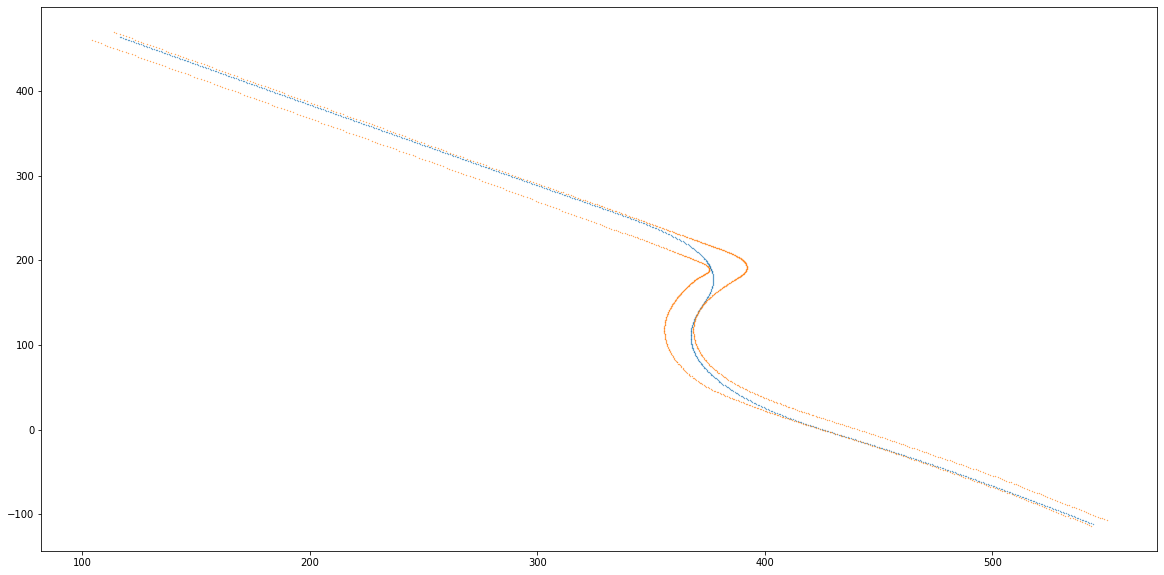

In [83]:
plt.figure(figsize=(20,10))
plt.scatter(data=funnyLap, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
plt.scatter(data=track, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
plt.show()

In [86]:
funnyLap['CURRENT_LAP_TIME_MS'].iloc[-1]

10677

## Building lap valid flag

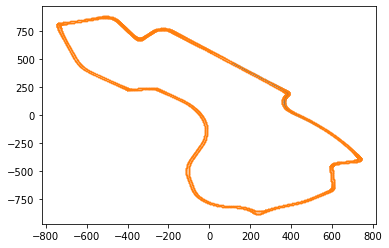

In [6]:
widthRefData = data22[(data22['SESSION_IDENTIFIER'].isin([1.020389177761665e+19, 1.0370910074670805e+19, 1.159612117810798e+19])) & (data22['LAP_NUM'] == 1)].copy()
# plt.figure(figsize=(20,10))
plt.scatter(data=widthRefData, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
plt.scatter(data=wholeTrack, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
# plt.savefig('refData.png', dpi=300)
plt.show()

117
There are 25 valid laps and 92 invalid laps in the 2024 data, as defined by them


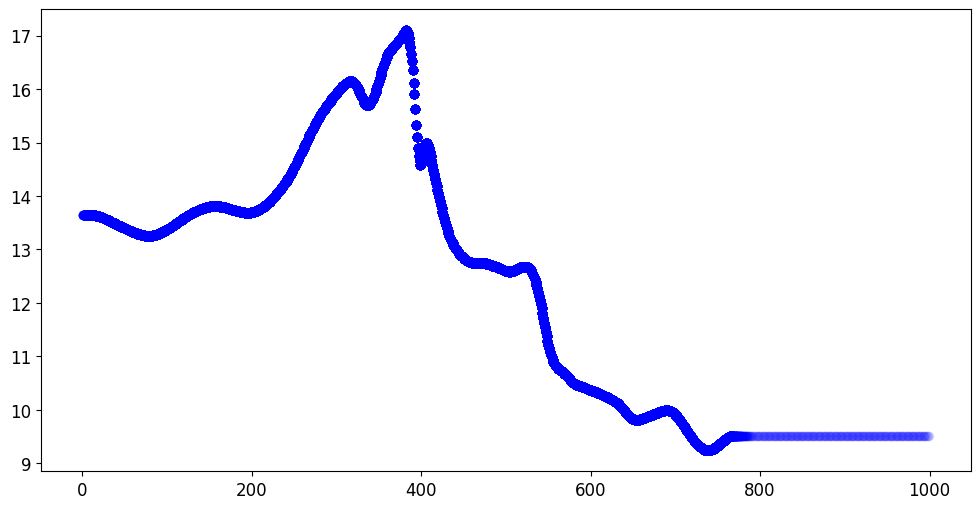

In [17]:
'''
Let's use the 2024 data to use that INVALID_LAP flag
The function to get track width doesn't work for the whole track
'''
lapsCount = len(data24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))
print(lapsCount)

goodLaps = data24[data24['INVALID_LAP'] == 0].copy()
badLaps = data24[data24['INVALID_LAP'] == 1].copy()

goodLapsCount = len(goodLaps.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))
badLapsCount = len(badLaps.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))

print(f'There are {goodLapsCount} valid laps and {badLapsCount} invalid laps in the 2024 data, as defined by them')

# Take one lap to speed things up for testing
# for name, one2024Lap in data24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']):
    # break
# one2024Lap = fun.update_data_w_width(one2024Lap, DIRECTORY)

data24 = fun.update_data_w_width(data24, DIRECTORY)

'''
Check that track width works
'''
plt.scatter('LAP_DISTANCE', 'TRACKWIDTH', c='b', data=data24, alpha=0.1)
plt.show()
data24 = fun.update_data_w_distances(data24, DIRECTORY)

In [18]:
buffers = np.linspace(0.1,1.6, 32)
dfCols = ['buffer', 'bothValid', 'bothInvalid', 'type1', 'type2']
agreementTable = pd.DataFrame(columns=dfCols)

for buffer in buffers.round(2):
    newData24 = data24[['SESSION_IDENTIFIER', 'LAP_NUM', 'WORLDPOSX', 'WORLDPOSY', 'TRACKWIDTH', 'DISTFROMLEFT', 'DISTFROMRIGHT', 'USER_TRACKWIDTH', 'INVALID_LAP']].copy()
    newData24['DIFF'] = newData24['TRACKWIDTH'] + buffer - newData24['USER_TRACKWIDTH']
    newData24['OFF_TRACK'] = np.where(newData24['TRACKWIDTH'] + buffer < newData24['USER_TRACKWIDTH'], 1, 0)
    newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)

    bothValid = newData24[(newData24['MY_INVALID_LAP'] == 0) & (newData24['INVALID_LAP'] == 0)].copy()
    bothInvalid = newData24[(newData24['MY_INVALID_LAP'] == 1) & (newData24['INVALID_LAP'] == 1)].copy()

    # We think valid and they think invalid
    type1disagreement = newData24[(newData24['MY_INVALID_LAP'] == 0) & (newData24['INVALID_LAP'] == 1)].copy()
    # We think invalid and they think valid
    type2disagreement = newData24[(newData24['MY_INVALID_LAP'] == 1) & (newData24['INVALID_LAP'] == 0)].copy()

    newRow = pd.DataFrame([[buffer, 
                            len(bothValid.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])), 
                            len(bothInvalid.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])),
                            len(type1disagreement.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])),
                            len(type2disagreement.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))
                            ]], columns=dfCols
                        )
    agreementTable = pd.concat([newRow, agreementTable])
    print(
        f"""
        For buffer size {newRow.loc[0]['buffer']}, we have {newRow.loc[0]['bothValid']} where we both think its valid, 
        {newRow.loc[0]['bothInvalid']} where we both think its invalid, 
        {newRow.loc[0]['type1']} cases where we think its valid and they don't,
        and {newRow.loc[0]['type2']} cases where we think its invalid and they think its fine
        """
        )
    
agreementTable = agreementTable.sort_values(by='buffer').reset_index(drop=True)

/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agreementTable = pd.concat([newRow, agreementTable])
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max>


        For buffer size 0.1, we have 15.0 where we both think its valid, 
        75.0 where we both think its invalid, 
        17.0 cases where we think its valid and they don't,
        and 10.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.15, we have 15.0 where we both think its valid, 
        75.0 where we both think its invalid, 
        17.0 cases where we think its valid and they don't,
        and 10.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.2, we have 16.0 where we both think its valid, 
        75.0 where we both think its invalid, 
        17.0 cases where we think its valid and they don't,
        and 9.0 cases where we think its invalid and they think its fine
        


/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is cu


        For buffer size 0.25, we have 17.0 where we both think its valid, 
        75.0 where we both think its invalid, 
        17.0 cases where we think its valid and they don't,
        and 8.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.29, we have 17.0 where we both think its valid, 
        75.0 where we both think its invalid, 
        17.0 cases where we think its valid and they don't,
        and 8.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.34, we have 18.0 where we both think its valid, 
        75.0 where we both think its invalid, 
        17.0 cases where we think its valid and they don't,
        and 7.0 cases where we think its invalid and they think its fine
        


/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is cu


        For buffer size 0.39, we have 20.0 where we both think its valid, 
        74.0 where we both think its invalid, 
        18.0 cases where we think its valid and they don't,
        and 5.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.44, we have 20.0 where we both think its valid, 
        74.0 where we both think its invalid, 
        18.0 cases where we think its valid and they don't,
        and 5.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.49, we have 21.0 where we both think its valid, 
        73.0 where we both think its invalid, 
        19.0 cases where we think its valid and they don't,
        and 4.0 cases where we think its invalid and they think its fine
        


/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is cu


        For buffer size 0.54, we have 22.0 where we both think its valid, 
        70.0 where we both think its invalid, 
        22.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.58, we have 22.0 where we both think its valid, 
        69.0 where we both think its invalid, 
        23.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.63, we have 22.0 where we both think its valid, 
        69.0 where we both think its invalid, 
        23.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        


/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is cu


        For buffer size 0.68, we have 22.0 where we both think its valid, 
        69.0 where we both think its invalid, 
        23.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.73, we have 22.0 where we both think its valid, 
        69.0 where we both think its invalid, 
        23.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.78, we have 22.0 where we both think its valid, 
        67.0 where we both think its invalid, 
        25.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        


/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is cu


        For buffer size 0.83, we have 22.0 where we both think its valid, 
        66.0 where we both think its invalid, 
        26.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.87, we have 22.0 where we both think its valid, 
        64.0 where we both think its invalid, 
        28.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.92, we have 22.0 where we both think its valid, 
        63.0 where we both think its invalid, 
        29.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 0.97, we have 22.0 where we both think its valid, 
        61.0 where we both think its invalid, 
        31.0 cases where we think its valid and they don't,
        and 3.0 cases 

/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is cu


        For buffer size 1.07, we have 22.0 where we both think its valid, 
        60.0 where we both think its invalid, 
        32.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 1.12, we have 22.0 where we both think its valid, 
        59.0 where we both think its invalid, 
        33.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 1.16, we have 22.0 where we both think its valid, 
        59.0 where we both think its invalid, 
        33.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        


/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is cu


        For buffer size 1.21, we have 22.0 where we both think its valid, 
        58.0 where we both think its invalid, 
        34.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 1.26, we have 22.0 where we both think its valid, 
        58.0 where we both think its invalid, 
        34.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 1.31, we have 22.0 where we both think its valid, 
        57.0 where we both think its invalid, 
        35.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        


/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is cu


        For buffer size 1.36, we have 22.0 where we both think its valid, 
        57.0 where we both think its invalid, 
        35.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 1.41, we have 22.0 where we both think its valid, 
        57.0 where we both think its invalid, 
        35.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 1.45, we have 22.0 where we both think its valid, 
        57.0 where we both think its invalid, 
        35.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        


/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is cu


        For buffer size 1.5, we have 22.0 where we both think its valid, 
        57.0 where we both think its invalid, 
        35.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 1.55, we have 22.0 where we both think its valid, 
        57.0 where we both think its invalid, 
        35.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        

        For buffer size 1.6, we have 22.0 where we both think its valid, 
        57.0 where we both think its invalid, 
        35.0 cases where we think its valid and they don't,
        and 3.0 cases where we think its invalid and they think its fine
        


/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_16532/2359265462.py:9: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)


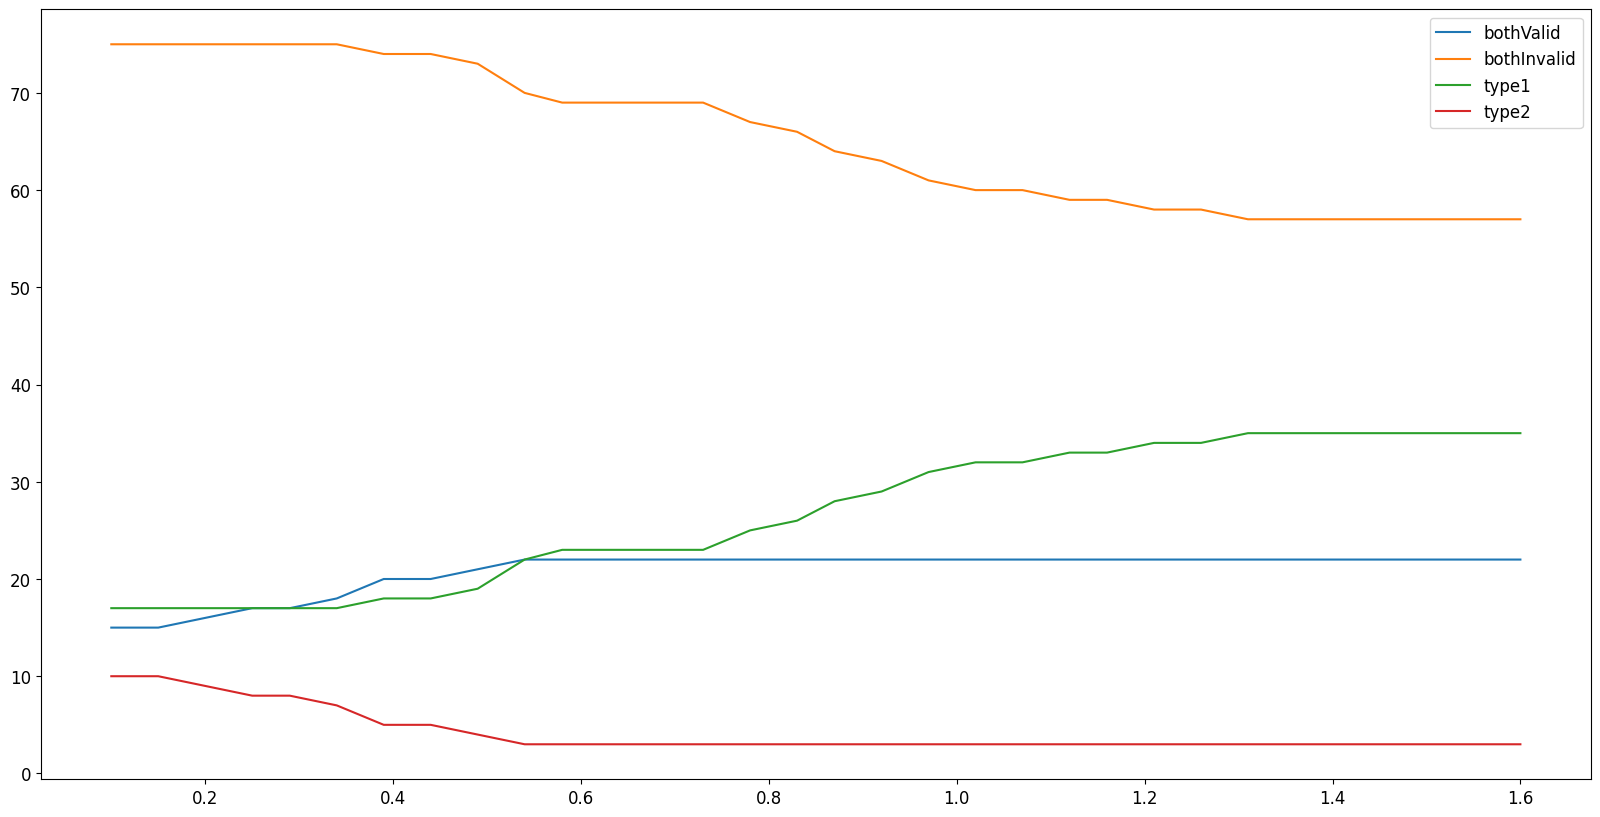

In [19]:
plt.figure(figsize=(20,10))
plt.plot('buffer', 'bothValid', data=agreementTable)
plt.plot('buffer', 'bothInvalid', data=agreementTable)
plt.plot('buffer', 'type1', data=agreementTable)
plt.plot('buffer', 'type2', data=agreementTable)
plt.legend()
plt.show()

In [39]:
agreementTable

,buffer,bothValid,bothInvalid,type1,type2
0,0.1,14,75,17,10
1,0.15,14,75,17,10
2,0.2,15,75,17,9
3,0.25,16,75,17,8
4,0.29,16,75,17,8
5,0.34,17,75,17,7
6,0.39,19,74,18,5
7,0.44,19,74,18,5
8,0.49,20,74,18,4
9,0.54,21,70,22,3


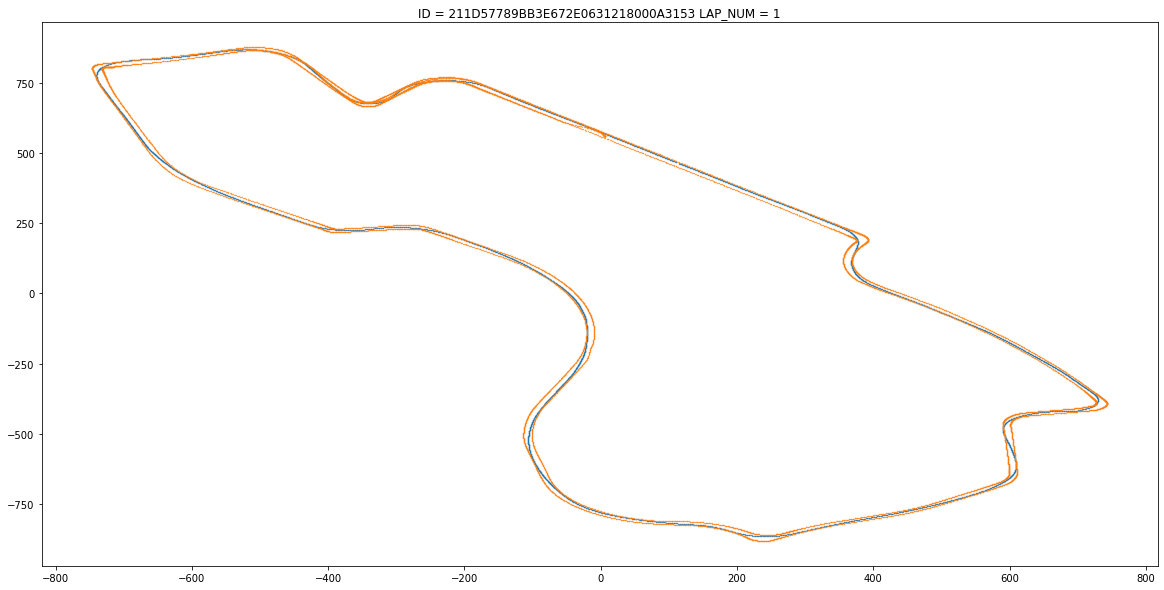

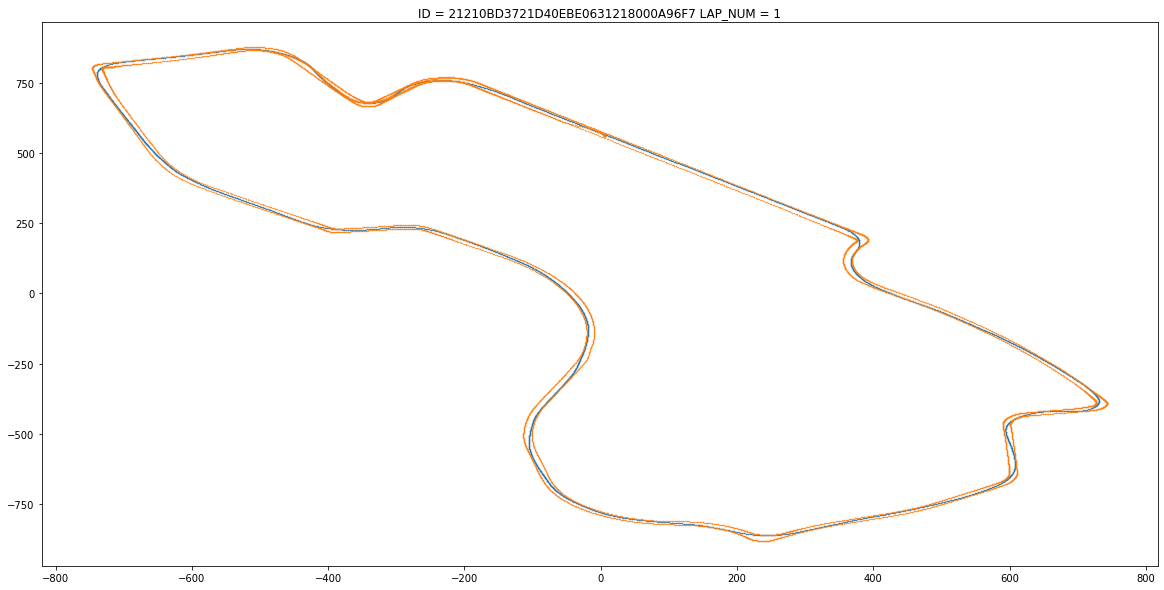

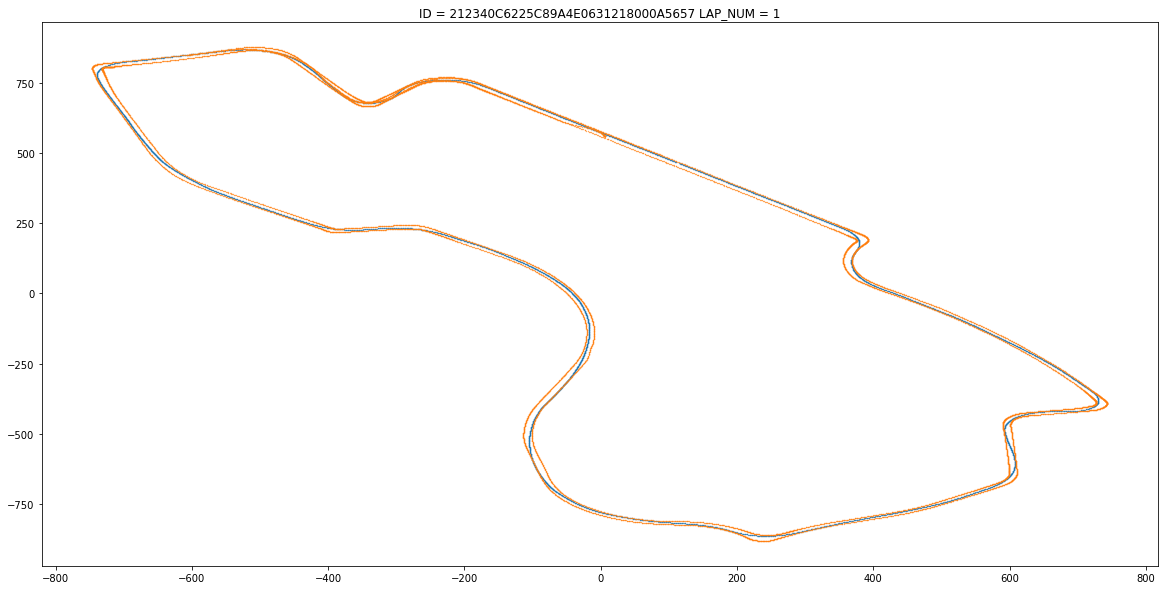

In [67]:
'''
Let's inspect some of the hockey sticks - whats the difference between blue at 0.54 and green at 0.78
'''
buffers = [0.54, 0.78]

def get_validity_check_dfs(df, buffer):
    newData24 = df[['SESSION_IDENTIFIER', 'LAP_NUM', 'WORLDPOSX', 'WORLDPOSY', 'TRACKWIDTH', 'DISTFROMLEFT', 'DISTFROMRIGHT', 'USER_TRACKWIDTH', 'INVALID_LAP']].copy()
    newData24['DIFF'] = newData24['TRACKWIDTH'] + buffer - newData24['USER_TRACKWIDTH']
    newData24['OFF_TRACK'] = np.where(newData24['TRACKWIDTH'] + buffer < newData24['USER_TRACKWIDTH'], 1, 0)
    newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)
    bothValid = newData24[(newData24['MY_INVALID_LAP'] == 0) & (newData24['INVALID_LAP'] == 0)].copy()
    bothInvalid = newData24[(newData24['MY_INVALID_LAP'] == 1) & (newData24['INVALID_LAP'] == 1)].copy()

    # We think valid and they think invalid
    type1disagreement = newData24[(newData24['MY_INVALID_LAP'] == 0) & (newData24['INVALID_LAP'] == 1)].copy()
    # We think invalid and they think valid
    type2disagreement = newData24[(newData24['MY_INVALID_LAP'] == 1) & (newData24['INVALID_LAP'] == 0)].copy()

    type1disagreement = type1disagreement.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])[['SESSION_IDENTIFIER', 'LAP_NUM']]
    keys = type1disagreement.groups.keys()
    return list(keys)

buffer1type1 = get_validity_check_dfs(data24, buffers[0])
buffer2type1 = get_validity_check_dfs(data24, buffers[-1])

assert len(buffer1type1) < len(buffer2type1)
for key in buffer1type1:
    buffer2type1.remove(key)

'''
These are laps that were marked as both invalid at buffer size 1 and now are being marked valid.
If they are valid by inspection go for second buffer size
if invalid go for first
'''
for id, lap in buffer2type1:
    plt.figure(figsize=(20,10))
    plt.title(f'ID = {id} LAP_NUM = 1')
    plt.scatter(data=wholeData24[(wholeData24['SESSION_IDENTIFIER'] == id) & (wholeData24['LAP_NUM'] == lap)], x='WORLDPOSX', y='WORLDPOSY', s=0.1)
    plt.scatter(data=wholeTrack, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
    plt.savefig(f'diffLaps/{id}.png', dpi=300)

In [68]:
'''
After discussion with team we will take the smaller buffer size
'''

'\nAfter discussion with team we will take the smaller buffer size\n'


    For the 17 where we think its valid and they think its invalid, it could be bad later in the track.
    


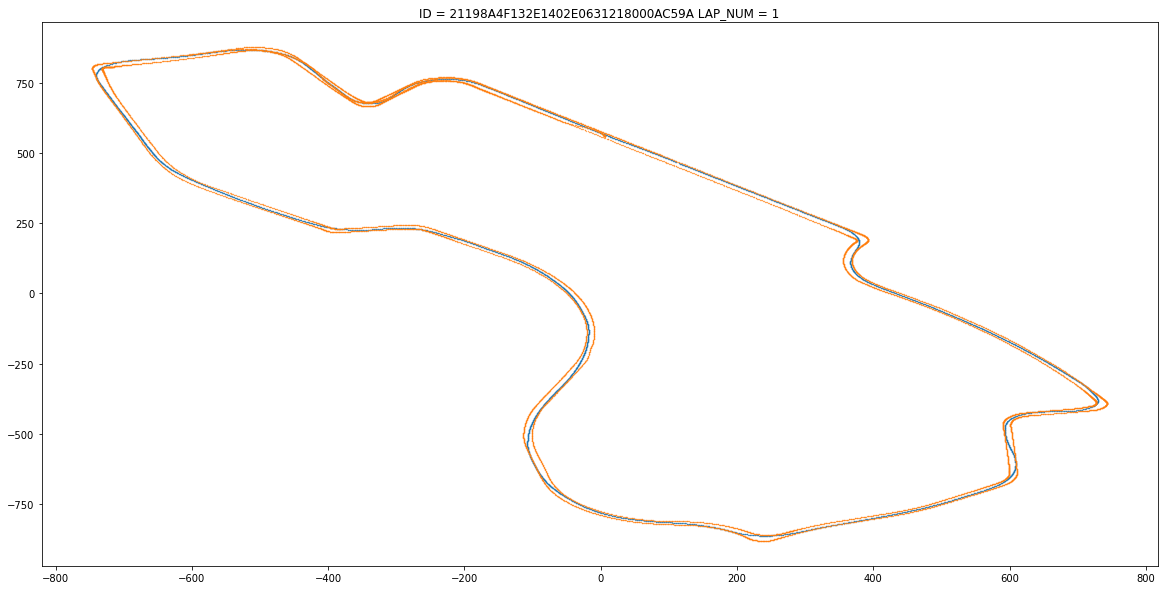

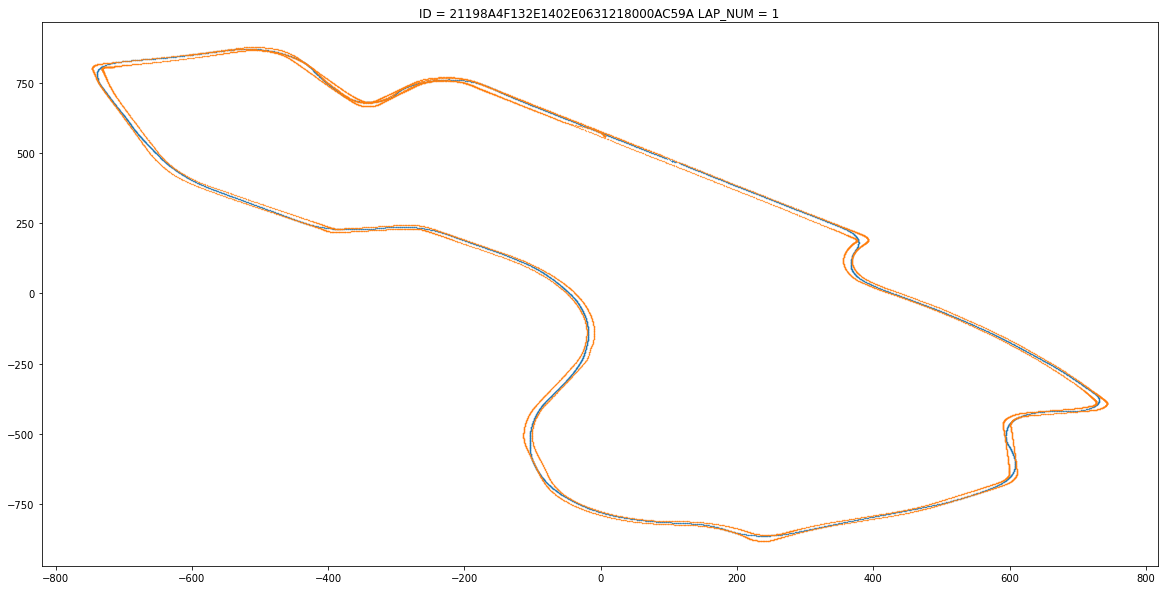

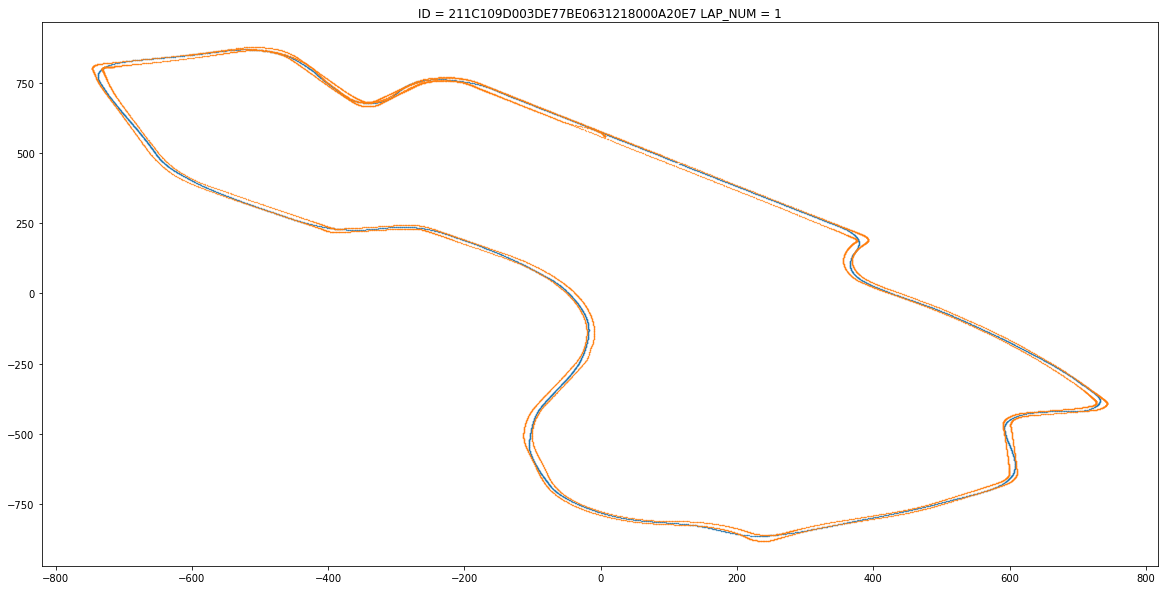

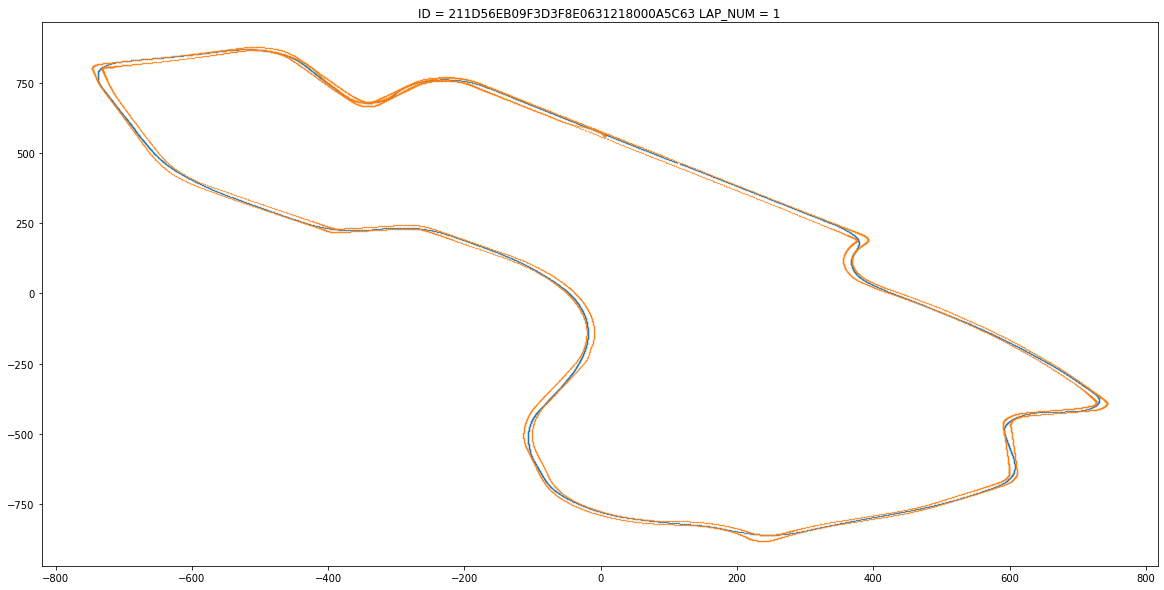

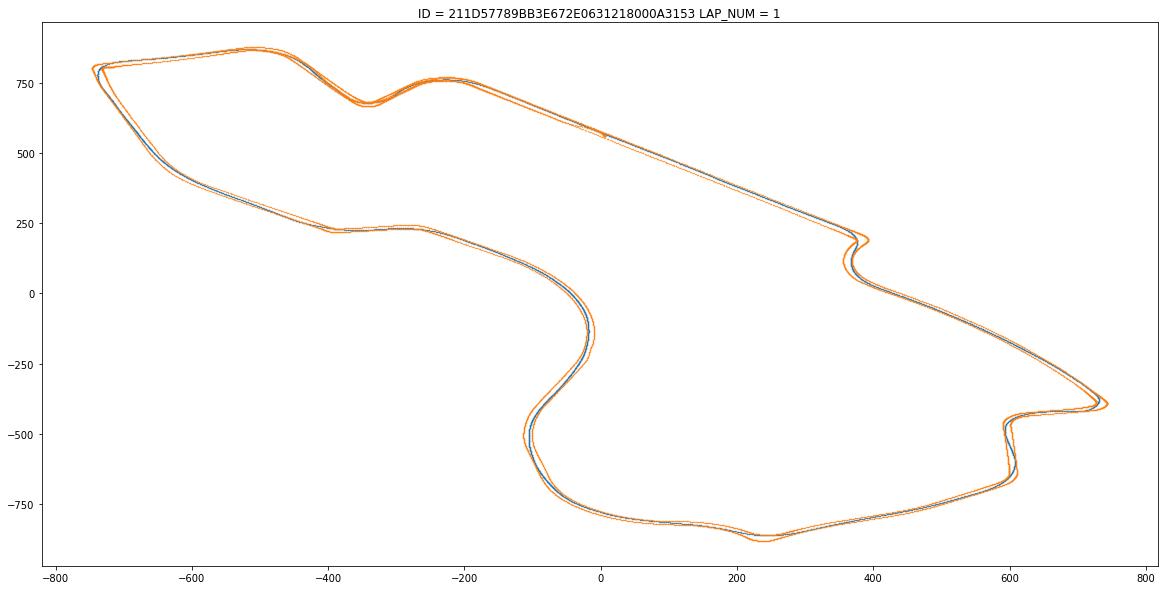

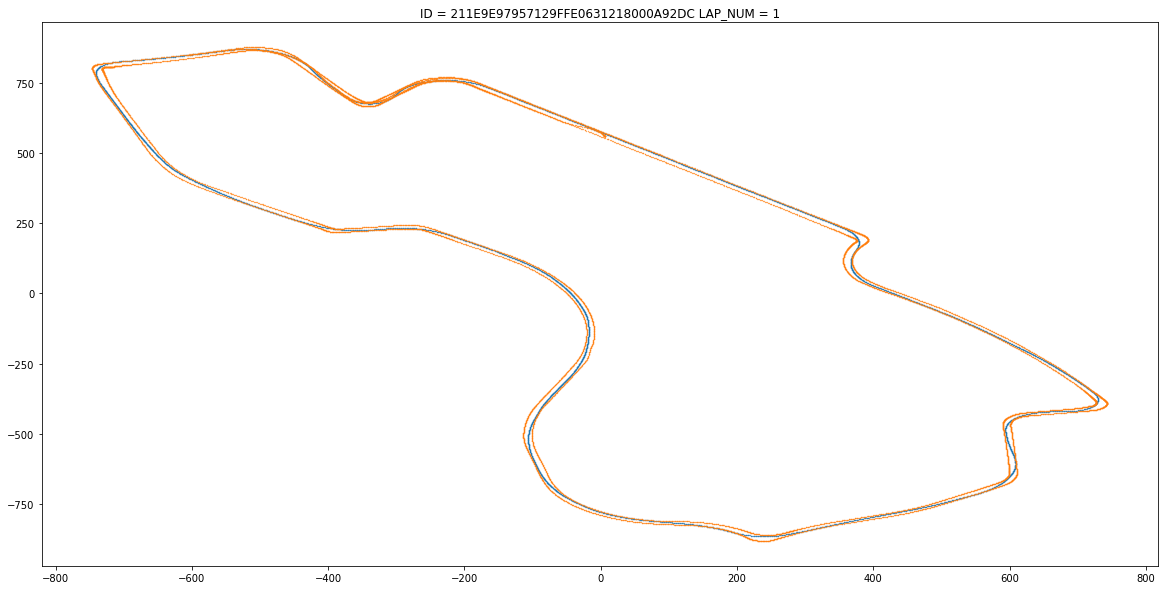

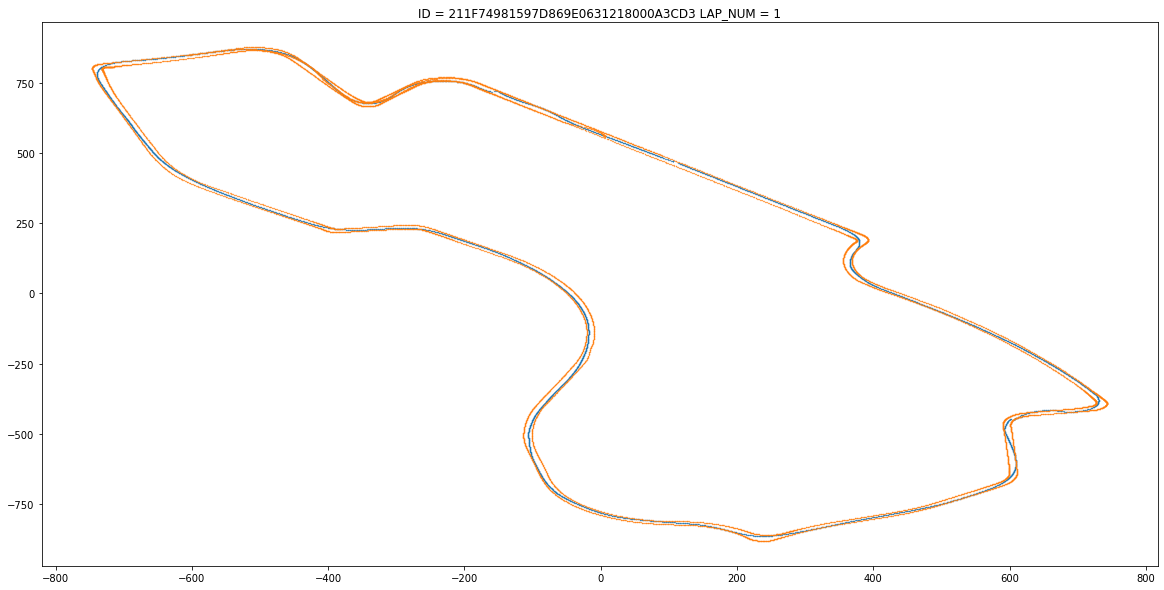

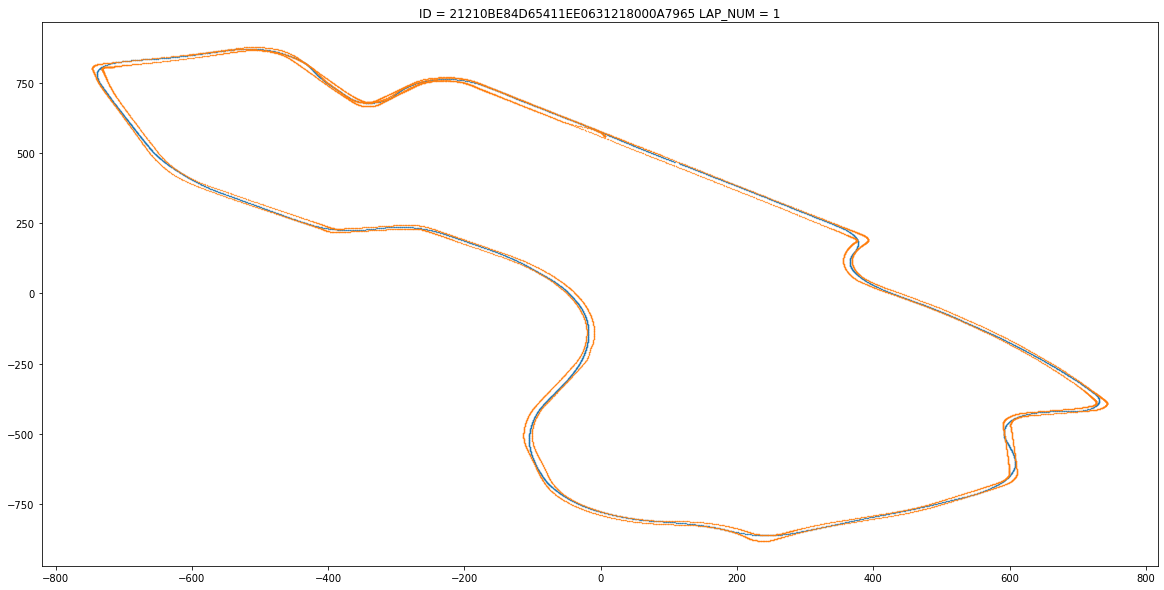

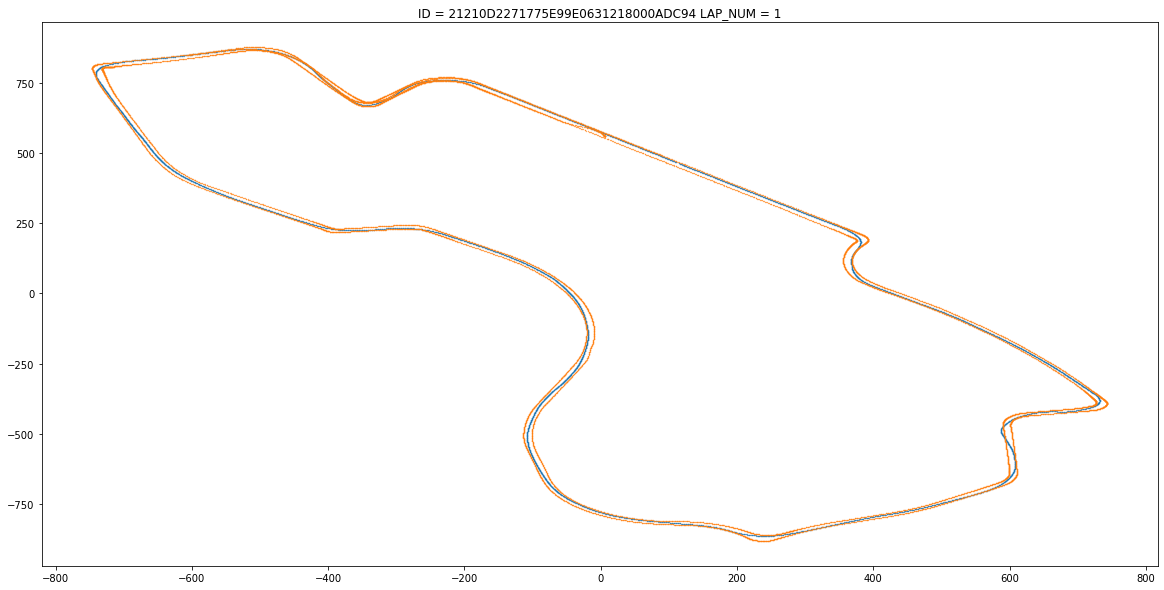

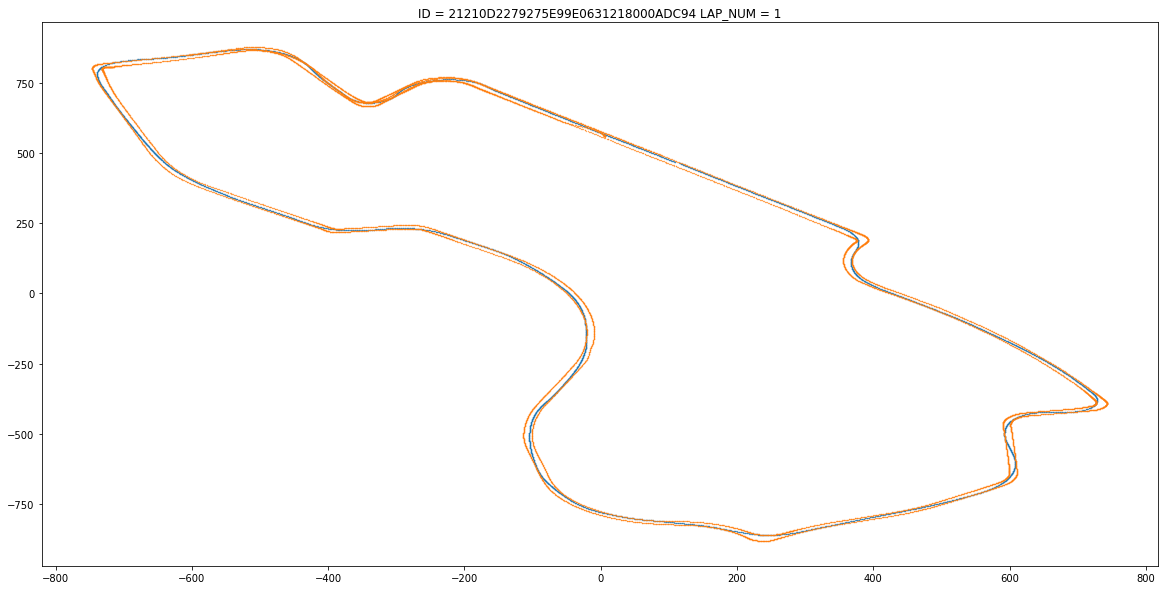

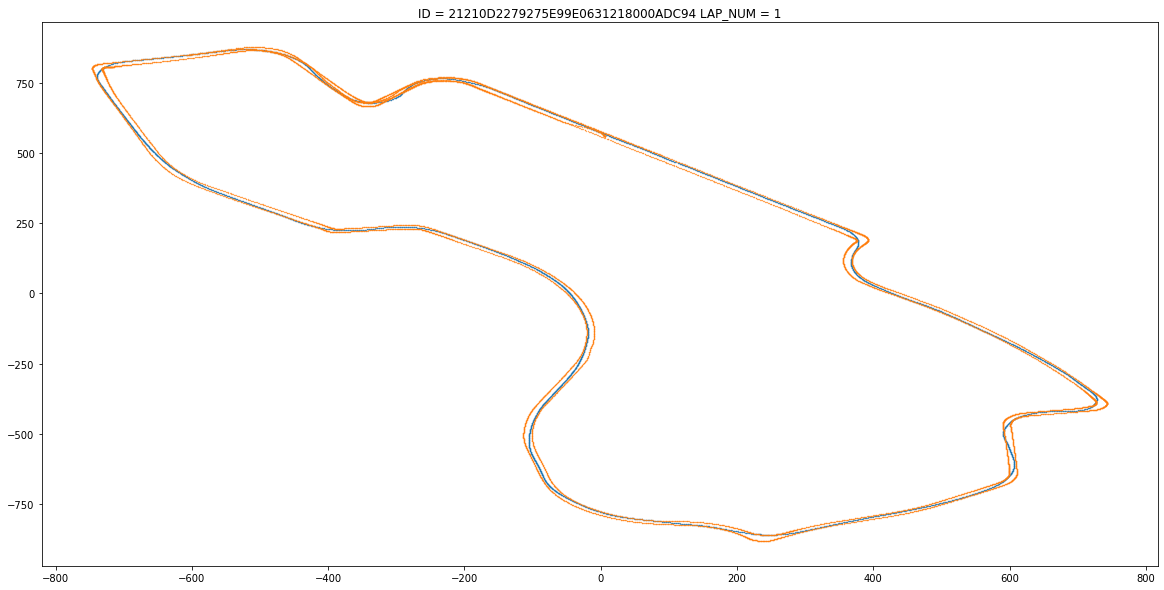

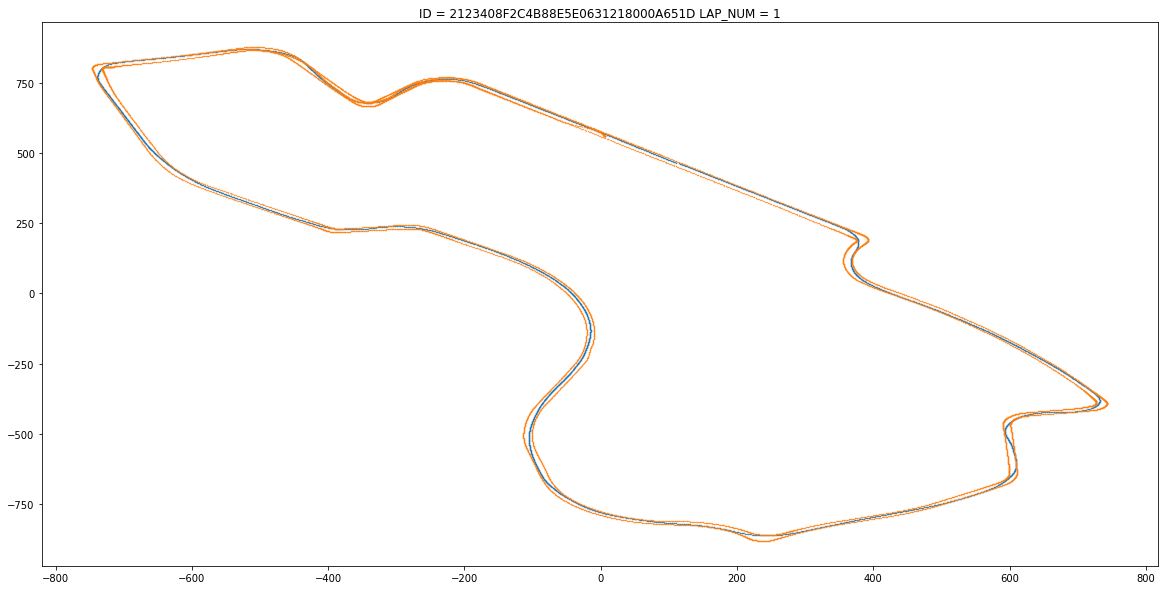

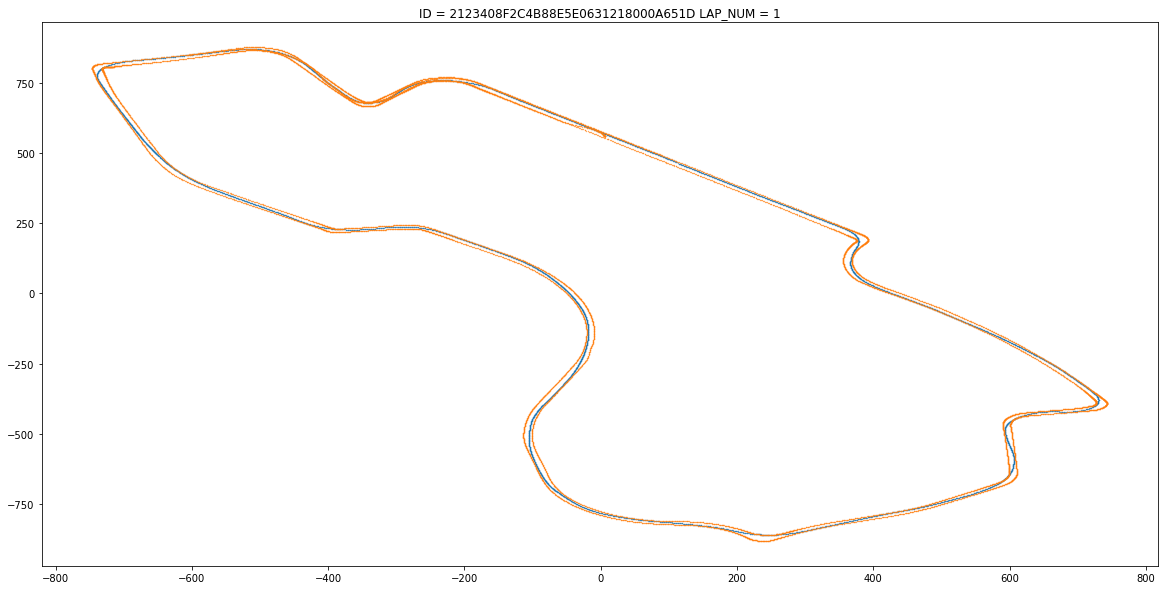

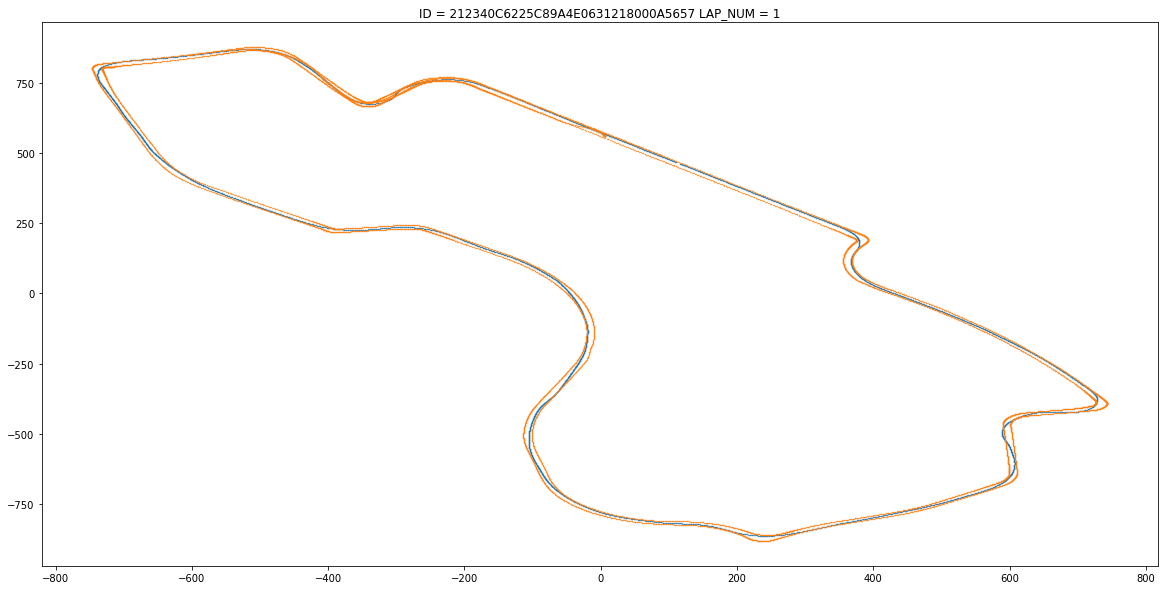

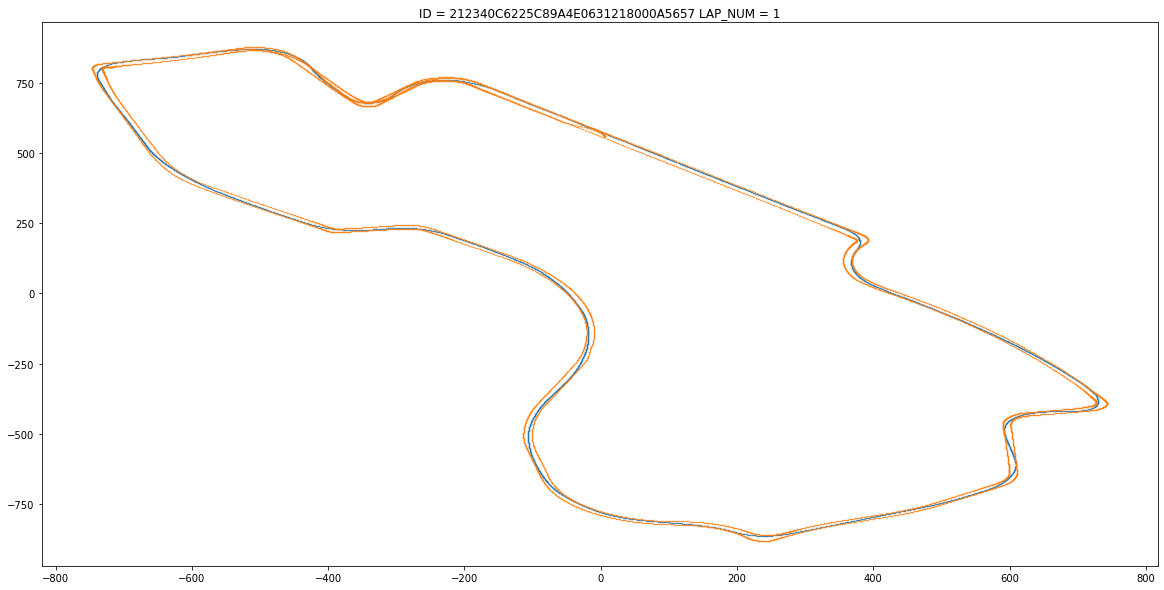

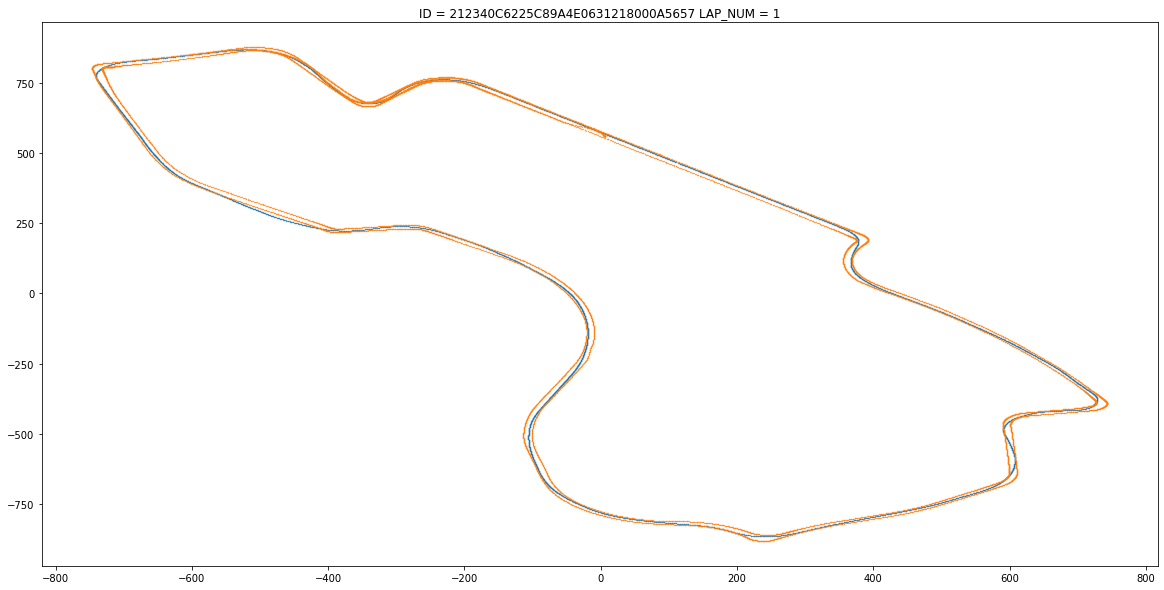

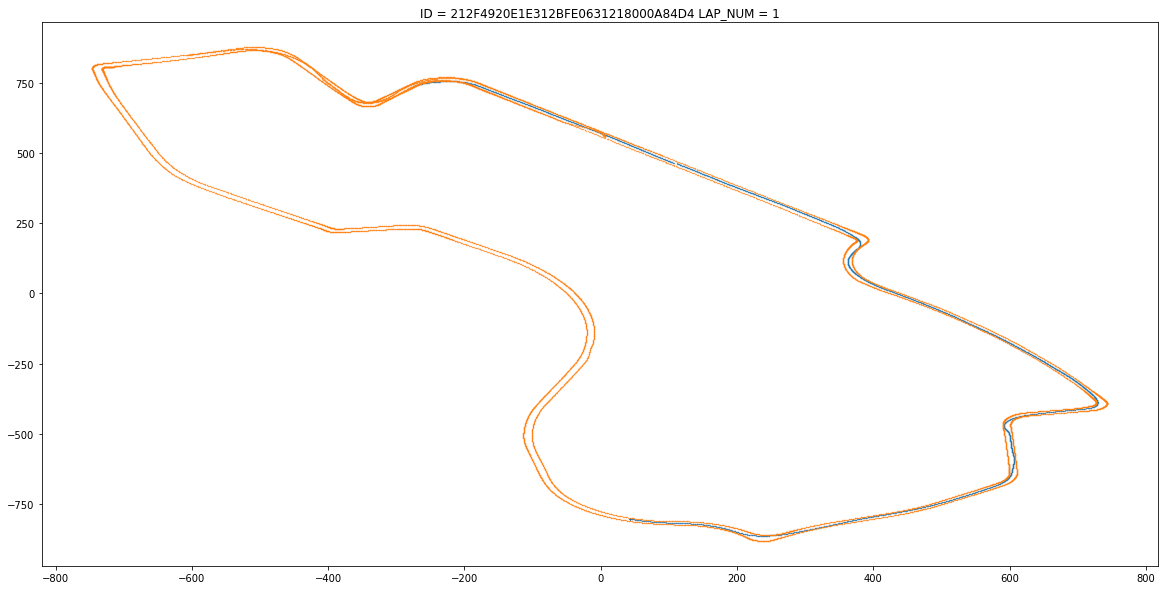

In [51]:
print(
    """
    For the 17 where we think its valid and they think its invalid, it could be bad later in the track.
    """
)
graphNo=1
for name, group in type1disagreement.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']):
    id, lap = group.iloc[0][['SESSION_IDENTIFIER', 'LAP_NUM']]
    plt.figure(figsize=(20,10))
    plt.title(f'ID = {id} LAP_NUM = 1')
    plt.scatter(data=wholeData24[(wholeData24['SESSION_IDENTIFIER'] == id) & (wholeData24['LAP_NUM'] == lap)], x='WORLDPOSX', y='WORLDPOSY', s=0.1)
    plt.scatter(data=wholeTrack, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
    plt.savefig(f'diffLaps/{id}.png', dpi=300)
    graphNo+=1


    For the 10 where we think its invalid and they think its fine let's see what happens.
    


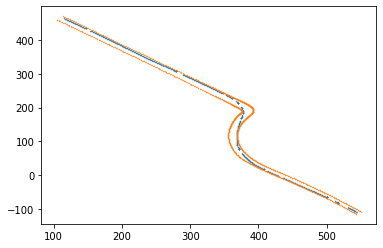

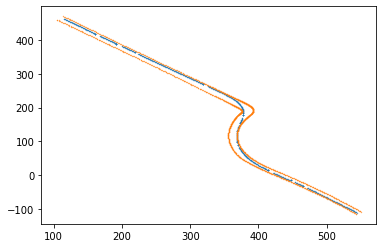

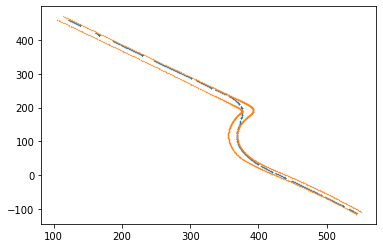

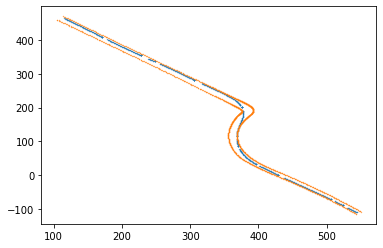

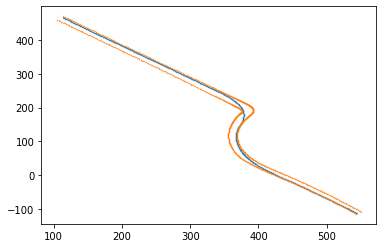

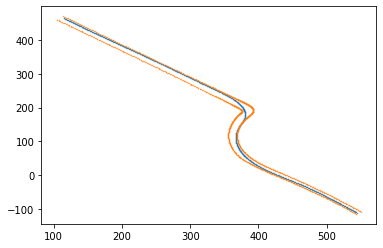

SESSION_IDENTIFIER    212F91F503F15DA4E0631218000AB2B2
LAP_NUM                                              2
WORLDPOSX                                   404.935006
WORLDPOSY                                    21.892828
TRACKWIDTH                                   10.592228
DISTFROMLEFT                                  7.360271
DISTFROMRIGHT                                 3.231306
USER_TRACKWIDTH                              10.591576
INVALID_LAP                                          0
DIFF                                          0.100652
OFF_TRACK                                            0
MY_INVALID_LAP                                     1.0
Name: 80958, dtype: object


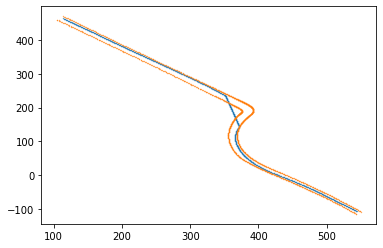

SESSION_IDENTIFIER    2130E60F0974B928E0631218000A99A7
LAP_NUM                                              2
WORLDPOSX                                   130.328498
WORLDPOSY                                   446.741792
TRACKWIDTH                                   13.573847
DISTFROMLEFT                                  4.956774
DISTFROMRIGHT                                 8.617426
USER_TRACKWIDTH                                13.5742
INVALID_LAP                                          0
DIFF                                          0.099647
OFF_TRACK                                            0
MY_INVALID_LAP                                     1.0
Name: 142982, dtype: object


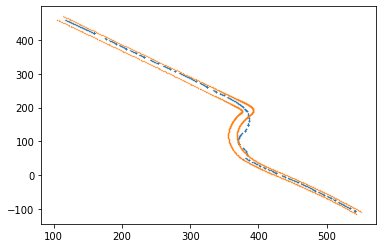

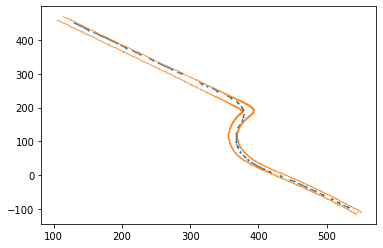

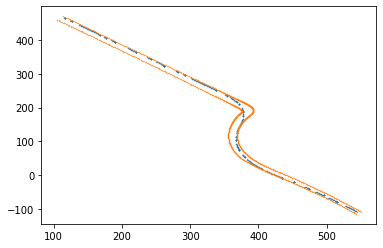

In [48]:
print(
    """
    For the 10 where we think its invalid and they think its fine let's see what happens.
    Looks like 2 are weird but the other ones we might be able to be more generous with the buffer.
    """
)

graphNo=1
for name, group in type2disagreement.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']):
    # Plot 7,8 are obviously bad
    if graphNo in (7,8):
        print(group.iloc[0])
    plt.scatter(data=group, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
    plt.scatter(data=track, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
    plt.show()
    graphNo+=1

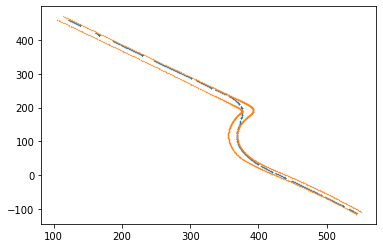

In [32]:
# plt.figure(figsize=(20,10))
plt.scatter(data=data24[(data24['SESSION_IDENTIFIER'] == testID2) & (data24['LAP_NUM'] == 1)], x='WORLDPOSX', y='WORLDPOSY', s=0.1)
plt.scatter(data=track, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
# plt.savefig('test2024Lap.png', dpi=300)
plt.show()

In [ ]:
'''
Testing around with buffer size.
'''
pltDict = {'buffer': [], 'agree': [], 'disagree': []}
for i in np.linspace(0,2,41):
    buffer = round(i,2)
    newData24 = data24[['SESSION_IDENTIFIER', 'LAP_NUM', 'TRACKWIDTH', 'DISTFROMLEFT', 'DISTFROMRIGHT', 'USER_TRACKWIDTH', 'INVALID_LAP']].copy()
    newData24['DIFF'] = newData24['TRACKWIDTH'] + buffer - newData24['USER_TRACKWIDTH']
    newData24['OFF_TRACK'] = np.where(newData24['TRACKWIDTH'] + buffer < newData24['USER_TRACKWIDTH'], 1, 0)
    newData24['MY_INVALID_LAP'] = newData24.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)

    agreement = newData24[((newData24['MY_INVALID_LAP'] == 0) & (newData24['INVALID_LAP'] == 0)) | ((newData24['MY_INVALID_LAP'] == 1) & (newData24['INVALID_LAP'] == 1))].copy()
    disagreement = newData24[((newData24['MY_INVALID_LAP'] == 0) & (newData24['INVALID_LAP'] == 1)) | ((newData24['MY_INVALID_LAP'] == 1) & (newData24['INVALID_LAP'] == 0))].copy()

    pltDict['buffer'].append(buffer)
    pltDict['agree'].append(len(agreement.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])))
    pltDict['disagree'].append(len(disagreement.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])))

plt.title('Number of agree and disagree laps by buffer amount')
plt.xlabel('Buffer amount')
plt.ylabel('Number of laps')
plt.plot(pltDict['buffer'], pltDict['agree'], label='Agreed validness')
plt.plot(pltDict['buffer'], pltDict['disagree'], label='Disagreed validness')
plt.legend()
plt.show()

## Creating a path valid flag

In [164]:
data22 = fun.update_data_w_width(data22, DIRECTORY)
'''
Check that it works

plt.scatter('LAP_DISTANCE', 'TRACKWIDTH', c='b', data=data22, alpha=0.1)
plt.show()
'''
data22 = fun.update_data_w_distances(data22, track)

In [189]:
data22.to_csv(DIRECTORY + '/tomUpdated2022Data.csv')

In [191]:
BUFFER = 0.1

newData22 = data22[['SESSION_IDENTIFIER', 'LAP_NUM', 'WORLDPOSX', 'WORLDPOSY', 'LAP_DISTANCE', 'TRACKWIDTH', 'DISTFROMLEFT', 'DISTFROMRIGHT', 'USER_TRACKWIDTH']].copy()
newData22['DIFF'] = newData22['TRACKWIDTH'] + BUFFER - newData22['USER_TRACKWIDTH']
newData22['OFF_TRACK'] = np.where(newData22['TRACKWIDTH'] + BUFFER < newData22['USER_TRACKWIDTH'], 1, 0)
newData22['INVALID_LAP'] = newData22.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)

goodLaps = newData22[newData22['INVALID_LAP'] == 0].copy()
badLaps = newData22[newData22['INVALID_LAP'] == 1].copy()
len(goodLaps)

goodLapsList = []
for name, group in goodLaps.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']):
    '''
    plt.scatter(x='WORLDPOSX', y='WORLDPOSY', data=track, s=0.1, c='b')
    plt.scatter(x='WORLDPOSX', y='WORLDPOSY', data=group, s=1, c='r')
    plt.show()
    '''
    goodLapsList.append(name)

badLapsCount = len(badLaps.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))
print(f'We found {len(goodLapsList)} laps that stay on track and {badLapsCount} duds')
# goodLaps.iloc[0]['SESSION_IDENTIFIER']
# newData22[newData22['SESSION_IDENTIFIER'] == 1.0852068761091482e+19]

We found 351 laps that stay on track and 486 duds


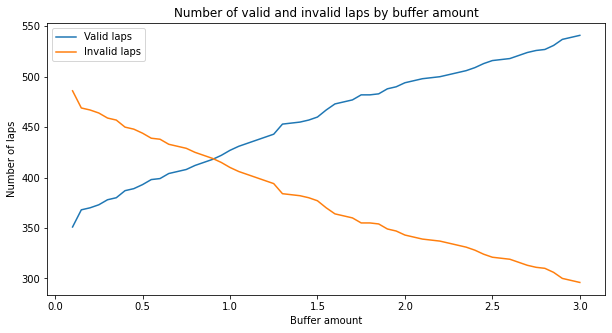

In [204]:
'''
Testing around with buffer size.
'''
pltDict = {'buffer': [], 'goodLaps': [], 'badLaps': []}
for i in np.linspace(0.1,3,59):
    buffer = round(i,2)
    newData22 = data22[['SESSION_IDENTIFIER', 'LAP_NUM', 'WORLDPOSX', 'WORLDPOSY', 'LAP_DISTANCE', 'TRACKWIDTH', 'DISTFROMLEFT', 'DISTFROMRIGHT', 'USER_TRACKWIDTH']].copy()
    newData22['DIFF'] = newData22['TRACKWIDTH'] + buffer - newData22['USER_TRACKWIDTH']
    newData22['OFF_TRACK'] = np.where(newData22['TRACKWIDTH'] + buffer < newData22['USER_TRACKWIDTH'], 1, 0)
    newData22['INVALID_LAP'] = newData22.groupby(['SESSION_IDENTIFIER', 'LAP_NUM'])['OFF_TRACK'].transform(max)

    goodLaps = newData22[newData22['INVALID_LAP'] == 0].copy()
    badLaps = newData22[newData22['INVALID_LAP'] == 1].copy()

    goodLapsCount = len(goodLaps.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))
    badLapsCount = len(badLaps.groupby(['SESSION_IDENTIFIER', 'LAP_NUM']))

    pltDict['buffer'].append(buffer)
    pltDict['goodLaps'].append(goodLapsCount)
    pltDict['badLaps'].append(badLapsCount)
    # print(f'For buffer {buffer}, we found {goodLapsCount} laps that stay on track and {badLapsCount} duds')

plt.title('Number of valid and invalid laps by buffer amount')
plt.xlabel('Buffer amount')
plt.ylabel('Number of laps')
plt.plot(pltDict['buffer'], pltDict['goodLaps'], label='Valid laps')
plt.plot(pltDict['buffer'], pltDict['badLaps'], label='Invalid laps')
plt.legend()
plt.show()

'''
I'm not sure if I'm missing something but I really didn't expect there to be a linear relationship
'''

In [175]:
newData22['DIFF'].idxmin()
newData22.loc[125841]

SESSION_IDENTIFIER    1.286913e+19
LAP_NUM               1.300000e+01
WORLDPOSX             4.747794e+02
WORLDPOSY             1.247524e+02
LAP_DISTANCE          4.017031e+02
TRACKWIDTH            1.469989e+01
DISTFROMLEFT          1.024273e+02
DISTFROMRIGHT         1.170169e+02
USER_TRACKWIDTH       2.194442e+02
DIFF                 -2.045943e+02
OFF_TRACK             1.000000e+00
INVALID_LAP           1.000000e+00
Name: 125841, dtype: float64

In [166]:
'''
This looks terrible! In fact the tracks we used as exemplar don't even make the cut-off so what the hell is happening?
There has to be something happening with our projection of track width. So, let's add a buffer to this (for the edge of the car).
'''

exemplarLaps = newData22[(newData22['SESSION_IDENTIFIER'].isin([1.020389177761665e+19, 1.0370910074670805e+19, 1.159612117810798e+19])) & (newData22['LAP_NUM'] == 1)]
exemplarLaps[exemplarLaps['OFF_TRACK'] == 1]
exemplarLaps['NEW_OFF_TRACK'] = np.where(exemplarLaps['TRACKWIDTH'] + BUFFER < exemplarLaps['USER_TRACKWIDTH'], 1, 0)
exemplarLaps[exemplarLaps['NEW_OFF_TRACK'] == 1]

/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_45282/1738413232.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exemplarLaps['NEW_OFF_TRACK'] = np.where(exemplarLaps['TRACKWIDTH'] + BUFFER < exemplarLaps['USER_TRACKWIDTH'], 1, 0)


,SESSION_IDENTIFIER,LAP_NUM,WORLDPOSX,WORLDPOSY,LAP_DISTANCE,TRACKWIDTH,DISTFROMLEFT,DISTFROMRIGHT,USER_TRACKWIDTH,OFF_TRACK,INVALID_LAP,NEW_OFF_TRACK


## Calculating track width 24/09

In [123]:
'''
Filter for one lap:
'''
lap1 = fun.filter_one_lap(data22, 4)
lap2 = fun.filter_one_lap(data22, 41)
lap3 = fun.filter_one_lap(data22, 9)
allLaps = pd.concat([lap1,lap2,lap3]).sort_values(by='LAP_DISTANCE').reset_index(drop=True)

'''
for i in range(40,50):
    lap2 = fun.filter_one_lap(data22, i)
    plt.scatter(data=track, x='WORLDPOSX', y='WORLDPOSY', c='b',s=0.1)
    plt.scatter(data=lap2, x='WORLDPOSX', y='WORLDPOSY', c='r',s=0.1)
    plt.show()
'''

# data22['TRACKWIDTH'] = np.interp(data22['LAP_DISTANCE'], allLaps['LAP_DISTANCE'], allLaps['USER_TRACKWIDTH'])

allLaps

trackWidthData = data22[(data22['SESSION_IDENTIFIER'].isin([1.020389177761665e+19, 1.0370910074670805e+19, 1.159612117810798e+19])) & (data22['LAP_NUM'] == 1)]
trackWidthData = trackWidthData[['LAP_DISTANCE', 'TRACKWIDTH']].sort_values(by='LAP_DISTANCE').reset_index(drop=True)

plt.subplot(1,3,1)
plt.scatter(data=track, x='WORLDPOSX', y='WORLDPOSY', c='b',s=0.1)
plt.scatter(data=lap1, x='WORLDPOSX', y='WORLDPOSY', c='r',s=0.1)
plt.subplot(1,3,2)
plt.scatter(data=track, x='WORLDPOSX', y='WORLDPOSY', c='b',s=0.1)
plt.scatter(data=lap2, x='WORLDPOSX', y='WORLDPOSY', c='r',s=0.1)
plt.subplot(1,3,3)
plt.scatter(data=track, x='WORLDPOSX', y='WORLDPOSY', c='b',s=0.1)
plt.scatter(data=lap3, x='WORLDPOSX', y='WORLDPOSY', c='r',s=0.1)
plt.show()

'''
Let's start by defining lap width for each of the points in the track
Going to use lap distance as the x variable
lap1 = fun.update_data_w_distances(lap1, track)
lap2 = fun.update_data_w_distances(lap2, track)
lap3 = fun.update_data_w_distances(lap3, track)
'''

'''
Plot the track width found by our three users

plt.subplot(1,3,1)
plt.plot('LAP_DISTANCE', 'DISTFROMLEFT', c='r', data=lap1)
plt.plot('LAP_DISTANCE', 'DISTFROMRIGHT', c='g', data=lap1)
plt.plot('LAP_DISTANCE', 'USER_TRACKWIDTH', c='b', data=lap1)
plt.subplot(1,3,2)
plt.plot('LAP_DISTANCE', 'DISTFROMLEFT', c='r', data=lap2)
plt.plot('LAP_DISTANCE', 'DISTFROMRIGHT', c='g', data=lap2)
plt.plot('LAP_DISTANCE', 'USER_TRACKWIDTH', c='b', data=lap2)
plt.subplot(1,3,3)
plt.plot('LAP_DISTANCE', 'DISTFROMLEFT', c='r', data=lap3)
plt.plot('LAP_DISTANCE', 'DISTFROMRIGHT', c='g', data=lap3)
plt.plot('LAP_DISTANCE', 'USER_TRACKWIDTH', c='b', data=lap3)
plt.show()
'''

'''
Plot track width simultaneously

'''
plt.plot('LAP_DISTANCE', 'USER_TRACKWIDTH', c='b', data=lap1, label='lap1')
plt.plot('LAP_DISTANCE', 'USER_TRACKWIDTH', c='r', data=lap2, label='lap2')
plt.plot('LAP_DISTANCE', 'USER_TRACKWIDTH', c='g', data=lap3, label='lap3')
plt.legend()
plt.title('Track width by lap distance for individual data sets')
plt.xlabel('Lap distance')
plt.ylabel('Track width')
plt.show()

allLaps = pd.concat([lap1,lap2,lap3]).sort_values(by='LAP_DISTANCE').reset_index(drop=True)
allLaps = allLaps[['LAP_DISTANCE', 'USER_TRACKWIDTH']]
print(
    f'''
    Df lap1 is of size {len(lap1)}
    Df lap2 is of size {len(lap2)}
    Df lap3 is of size {len(lap3)}
    Df allLaps is of size {len(allLaps)}
    '''
)
plt.plot('LAP_DISTANCE', 'USER_TRACKWIDTH', c='b', data=allLaps, label='lap1')
plt.title('Track width by lap distance for concatenated data sets')
plt.xlabel('Lap distance')
plt.ylabel('Track width')
plt.show()

print(np.interp(2, allLaps['LAP_DISTANCE'], allLaps['USER_TRACKWIDTH']))
# allLaps.head()
x1, y1 = allLaps.iloc[0]
x2, y2 = allLaps.iloc[1]
m = (y2 - y1) / (x2 - x1)
print(y1 + m*(2 - x1))

KeyError: "['TRACKWIDTH'] not in index"

In [128]:
trackWidthData.columns
# plt.plot('LAP_DISTANCE', 'TRACKWIDTH')

Index(['SESSION_IDENTIFIER', 'FRAME', 'LAP_NUM', 'SECTOR', 'LAP_DISTANCE',
       'CURRENT_LAP_TIME_MS', 'SECTOR_1_TIME_MS', 'SECTOR_2_TIME_MS',
       'LAP_TIME_MS', 'SECTOR_3_MS', 'SPEED_KPH', 'THROTTLE', 'BRAKE', 'GEAR',
       'ENGINE_RPM', 'STEERING', 'YAW', 'PITCH', 'ROLL', 'WORLDPOSX',
       'WORLDPOSY', 'WORLDPOSZ', 'WORLDFORWARDDIRX', 'WORLDFORWARDDIRY',
       'WORLDFORWARDDIRZ', 'WORLDRIGHTDIRX', 'WORLDRIGHTDIRY',
       'WORLDRIGHTDIRZ'],
      dtype='object')

## Finding finish line 20/09 

In [5]:
# From Kento's work
lastPoint = wholeData22.iloc[182302].to_frame().T
# lastPoint = lastPoint[['WORLDPOSX', 'WORLDPOSY']]

lastPointLeftProj = fun.get_proj_on_side(wholeLeft, fun.df_to_list(lastPoint, 0))
lastPointRightProj = fun.get_proj_on_side(wholeRight, fun.df_to_list(lastPoint, 0))

plt.scatter(data=wholeLeft, x='WORLDPOSX', y='WORLDPOSY', c='b', s=10)
plt.scatter(data=wholeRight, x='WORLDPOSX', y='WORLDPOSY', c='b', s=10)
plt.scatter(data=lastPoint, x='WORLDPOSX', y='WORLDPOSY', c='g', s=10)
plt.scatter(data=lastPointLeftProj, x='WORLDPOSX', y='WORLDPOSY', c='r', s=10)
plt.scatter(data=lastPointRightProj, x='WORLDPOSX', y='WORLDPOSY', c='r', s=10)
plt.axis('equal')
plt.xlim(540,560)
plt.ylim(-150,-80)
plt.show()

'''
Now we can get the values of the points so that we can add this logic to the functions file
'''
print('Left is:\n', lastPointLeftProj, '\n\nRight is:\n', lastPointRightProj)

fun.plot_track_2d(wholeTrack)

AttributeError: 'NoneType' object has no attribute 'iloc'

## Fixing start of track 18/09

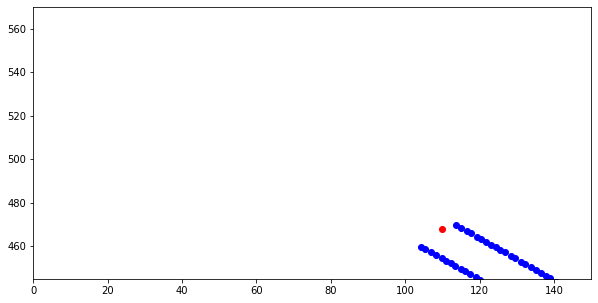

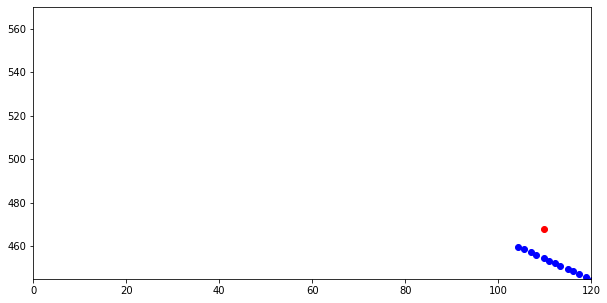

Empty DataFrame
Columns: [REFTYPE, SESSION_IDENTIFIER, FRAME, WORLDPOSX, WORLDPOSY, WORLDPOSZ]
Index: []


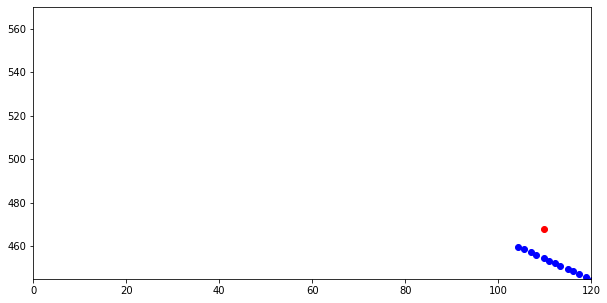

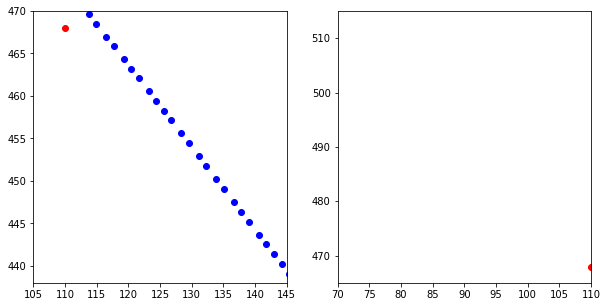

This is where we have jumps in FRAME count - could be where we start repeating lines
16    3.0
Name: FRAME, dtype: float64
Empty DataFrame
Columns: [REFTYPE, SESSION_IDENTIFIER, FRAME, WORLDPOSX, WORLDPOSY, WORLDPOSZ]
Index: []
Empty DataFrame
Columns: [REFTYPE, SESSION_IDENTIFIER, FRAME, WORLDPOSX, WORLDPOSY, WORLDPOSZ]
Index: []
Empty DataFrame
Columns: [REFTYPE, SESSION_IDENTIFIER, FRAME, WORLDPOSX, WORLDPOSY, WORLDPOSZ]
Index: []


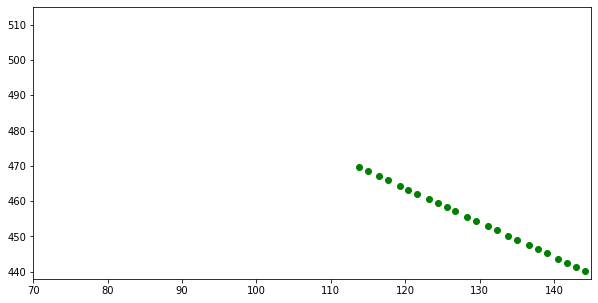

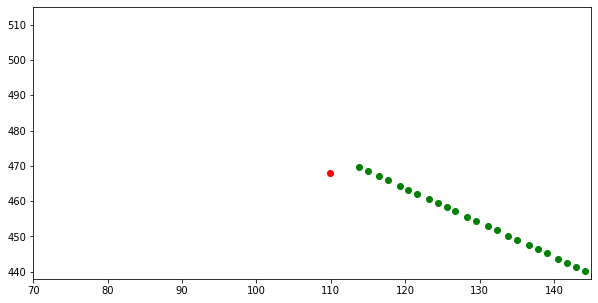

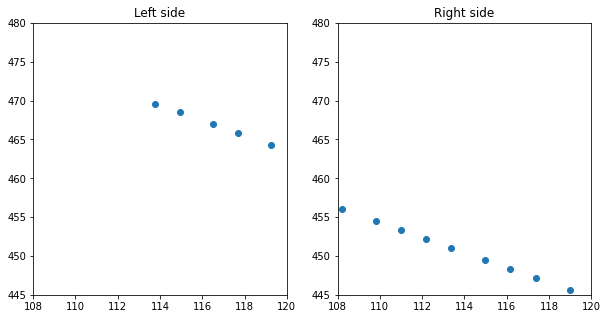

    WORLDPOSX   WORLDPOSY  WORLDPOSZ
0  109.943344  467.951904   3.136914
Empty DataFrame
Columns: [REFTYPE, SESSION_IDENTIFIER, FRAME, WORLDPOSX, WORLDPOSY, WORLDPOSZ]
Index: []
Empty DataFrame
Columns: [REFTYPE, SESSION_IDENTIFIER, FRAME, WORLDPOSX, WORLDPOSY, WORLDPOSZ]
Index: []


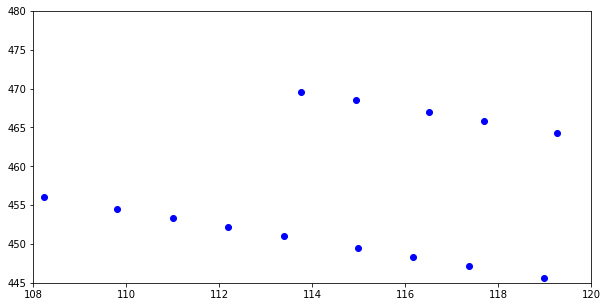

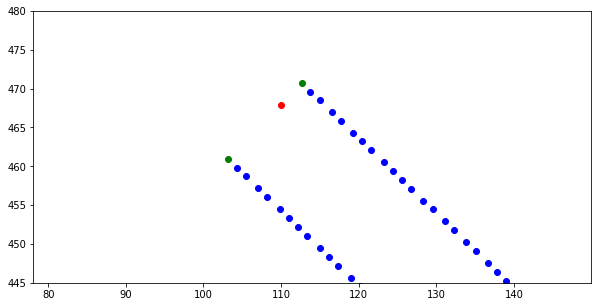

Left is:
     WORLDPOSX  WORLDPOSY
0  112.623076  470.73547 

Right is:
     WORLDPOSX   WORLDPOSY
0  103.154432  460.917033


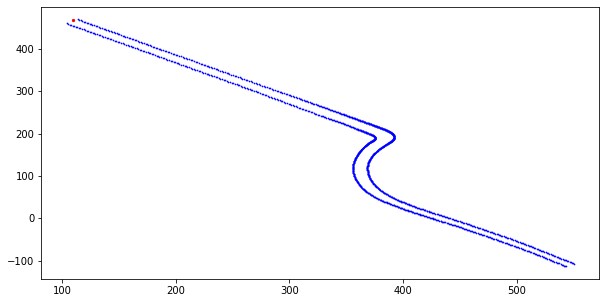

In [29]:
plt.rcParams['figure.figsize'] = [10, 5]

start = fun.get_start()
track = fun.load_track_section(DIRECTORY).sort_values('FRAME')
plt.scatter(data=track, x='WORLDPOSX', y='WORLDPOSY', c='b')
plt.scatter(data=start, x='WORLDPOSX', y='WORLDPOSY', c='r')
plt.xlim(0,150)
plt.ylim(445,570)
plt.show()

"""
Let's start by trying to get rid of the double line on the both sides of the track. It way into the back of the track but let's just cut it off early by getting rid of the last frames
"""

right = track[track.REFTYPE=='RIGHT'].reset_index(drop=True)
plt.scatter(data=right, x='WORLDPOSX', y='WORLDPOSY', c='b')
plt.scatter(data=start, x='WORLDPOSX', y='WORLDPOSY', c='r')
plt.xlim(0,120)
plt.ylim(445,570)
plt.show()

print(right[(right.WORLDPOSX < 10) & (right.WORLDPOSX > 0) & (right.WORLDPOSY < 560) & (right.WORLDPOSY > 540)])

plt.scatter(data=right[right.FRAME < 6395], x='WORLDPOSX', y='WORLDPOSY', c='b')
plt.scatter(data=start, x='WORLDPOSX', y='WORLDPOSY', c='red')
plt.xlim(0,120)
plt.ylim(445,570)
plt.show()

"""
Now, let's work on the left side
"""
left = track[track.REFTYPE=='LEFT'].reset_index(drop=True)
plt.subplot(1,2,1)
plt.scatter(data=left, x='WORLDPOSX', y='WORLDPOSY', c='b')
plt.scatter(data=start, x='WORLDPOSX', y='WORLDPOSY', c='red')
plt.xlim(105,145)
plt.ylim(438,470)
plt.subplot(1,2,2)
plt.scatter(data=left, x='WORLDPOSX', y='WORLDPOSY', c='b')
plt.scatter(data=start, x='WORLDPOSX', y='WORLDPOSY', c='red')
plt.xlim(70,110)
plt.ylim(465,515)
plt.show()

testLeft = left[(left.WORLDPOSX < 145) & (left.WORLDPOSX > 70) & (left.WORLDPOSY < 515) & (left.WORLDPOSY > 438)]
diffLeft = testLeft['FRAME'].diff()
print('This is where we have jumps in FRAME count - could be where we start repeating lines')
print(diffLeft[diffLeft > 2])
print(testLeft.loc[52:680])
print(testLeft.loc[728:729])
print(testLeft.loc[736:5375])

plt.scatter(data=left[left.FRAME <= 56], x='WORLDPOSX', y='WORLDPOSY', c='b')
plt.scatter(data=left[(left.FRAME >= 807) & (left.FRAME <= 890)], x='WORLDPOSX', y='WORLDPOSY', c='g')
plt.scatter(data=left[(left.FRAME >= 6088)], x='WORLDPOSX', y='WORLDPOSY', c='r')
plt.xlim(70,145)
plt.ylim(438,515)
plt.show()

plt.scatter(data=left[left.FRAME < 6088], x='WORLDPOSX', y='WORLDPOSY', c='g')
plt.scatter(data=start, x='WORLDPOSX', y='WORLDPOSY', c='red')
plt.xlim(70,145)
plt.ylim(438,515)
plt.show()

'''
So, that problem is now fixed, but the start point still exists in the data sets - hiding behind the red dot I put in. See:
'''

plt.subplot(1,2,1)
plt.scatter(data=left[left.FRAME < 6088], x='WORLDPOSX', y='WORLDPOSY')
plt.xlim(108,120)
plt.ylim(445,480)
plt.title('Left side')
plt.subplot(1,2,2)
plt.scatter(data=right[right.FRAME < 6395], x='WORLDPOSX', y='WORLDPOSY')
plt.xlim(108,120)
plt.ylim(445,480)
plt.title('Right side')
plt.show()

print(start)
print(left[(left.FRAME == 0) | (left.FRAME == 56) | (left.FRAME == 57)])
print(right[(right.FRAME == 0) | (right.FRAME == 140) | (right.FRAME == 141)])

right = right[(right.FRAME < 6395) & (right.FRAME > 140)]
left = left[(left.FRAME < 6100) & (left.FRAME > 56)]
plt.scatter(data=right, x='WORLDPOSX', y='WORLDPOSY', c='b')
plt.scatter(data=left, x='WORLDPOSX', y='WORLDPOSY', c='b')
plt.xlim(108,120)
plt.ylim(445,480)
plt.show()

'''
We have a nice clean track! Now let's work on projecting our start point to the sides, for a nice easy cut off!
'''

startPoint = fun.df_to_list(start, 0)

def getProjectionOnSide(side: pd.DataFrame, startPoint):
    trackList = [] 
    for i in range(len(side)):
        trackList.append(fun.df_to_list(side, i))

    pointB1, pointB2 = fun.two_closest_points(startPoint, trackList)
    projA = fun.projection_values(startPoint, pointB1, pointB2)['projA']
    return pd.DataFrame(np.array([projA]), columns=['WORLDPOSX', 'WORLDPOSY'])

leftSideProj = getProjectionOnSide(left, startPoint)
rightSideProj = getProjectionOnSide(right, startPoint)

plt.scatter(data=right, x='WORLDPOSX', y='WORLDPOSY', c='b')
plt.scatter(data=left, x='WORLDPOSX', y='WORLDPOSY', c='b')
plt.scatter(data=start, x='WORLDPOSX', y='WORLDPOSY', c='r')
plt.scatter(data=leftSideProj, x='WORLDPOSX', y='WORLDPOSY', c='g')
plt.scatter(data=rightSideProj, x='WORLDPOSX', y='WORLDPOSY', c='g')
plt.axis('equal')
plt.xlim(108,120)
plt.ylim(445,480)
plt.show()


plt.scatter(data=left[(left.WORLDPOSX >= leftSideProj.WORLDPOSX.iloc[0]) & (left.WORLDPOSY <= leftSideProj.WORLDPOSY.iloc[0])], x='WORLDPOSX', y='WORLDPOSY', c='b', s=0.5)
plt.scatter(data=right[(right.WORLDPOSX >= rightSideProj.WORLDPOSX.iloc[0]) & (right.WORLDPOSY <= rightSideProj.WORLDPOSY.iloc[0])], x='WORLDPOSX', y='WORLDPOSY', c='b', s=0.5)
plt.scatter(data=start, x='WORLDPOSX', y='WORLDPOSY', c='r', s=5)

'''
Now we can get the values of the points so that we can add this logic to the functions file
'''
print('Left is:\n', leftSideProj, '\n\nRight is:\n', rightSideProj)

## Working on positioning

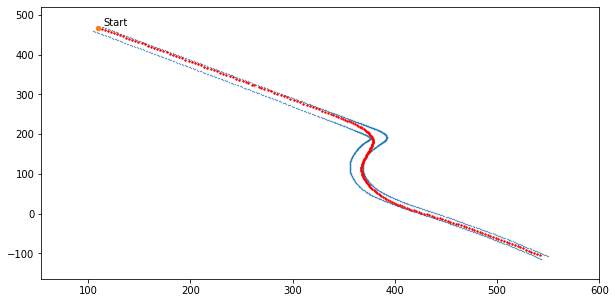

In [30]:
start = fun.get_start()
track = fun.load_track_section(DIRECTORY).sort_values('FRAME')

# Convert track dataframe into list of coordinates of track
def makeTrackList(track):
    return list(zip(track['WORLDPOSX'].to_list(), track['WORLDPOSY'].to_list()))

data = fun.load_race_data_2023(DIRECTORY)

# Returns one lap of data
# 0 completely stuffs turn 1 and drives all over the lap
# 1 is not as bad
# 2 is pretty clean
# 7 looks great
def filterOneLap(data, sessionIndex):
    return data[(data.SESSION_IDENTIFIER == data.SESSION_IDENTIFIER.unique()[sessionIndex]) & (data.LAP_NUM == 1)].reset_index(drop=True)

data = filterOneLap(data,0)

fun.plot_track_2d(track)
plt.scatter(data=data, x='WORLDPOSX', y='WORLDPOSY', s=2, c='red')

# Left to right distance methodology

## Approach 1:

Using algorithm 1, find the two closest points on one side of the track and calculate the perpendicular distance to the point. Then, we repeat with points on the other side of the track. Can encode distance from the left and distance from the right!

## Approach 2:
Find the projection of the edge of the track to the two closest points on the movement line. Same thing as above except the point of the car we calculate the distance from does not exist - it is just a projection. As a result, precede with Approach 1, as for our final output we want to have a XYZ point to refer to.

In [31]:
## Start with approach one

def update_data_with_distances(data, track):
    
    left, right = fun.get_track_sides(track)
    distFromLeft = []
    distFromRight = []

    for index, row in data[['FRAME', 'WORLDPOSX', 'WORLDPOSY']].iterrows():
        pointA = [row.WORLDPOSX, row.WORLDPOSY]

        leftProjA = fun.get_proj_on_side(left, pointA)
        distFromLeft.append(fun.euclid_distance(pointA, fun.df_to_list(leftProjA)))
        rightProjA = fun.get_proj_on_side(right, pointA)
        distFromRight.append(fun.euclid_distance(pointA, fun.df_to_list(rightProjA)))

        """
        # Plotting the projections
        
        closestLeftPoints = pd.DataFrame(np.array([pointLeftB1, pointLeftB2]), columns=['WORLDPOSX', 'WORLDPOSY'])
        closestRightPoints = pd.DataFrame(np.array([pointRightB1, pointRightB2]), columns=['WORLDPOSX', 'WORLDPOSY'])
        projLeft = pd.DataFrame(np.array([leftVals['projA']]), columns=['WORLDPOSX', 'WORLDPOSY'])
        projRight = pd.DataFrame(np.array([rightVals['projA']]), columns=['WORLDPOSX', 'WORLDPOSY'])

        plt.figure(figsize=(10,7))
        plt.axis('equal')
        plt.xlim(108,140)
        plt.ylim(420,480)
        plt.scatter(data=data.iloc[index], x='WORLDPOSX', y='WORLDPOSY', s=5, c='red')
        plt.scatter(data=trackLeft, x='WORLDPOSX', y='WORLDPOSY', s=1, c='blue')
        plt.scatter(data=trackRight, x='WORLDPOSX', y='WORLDPOSY', s=5, c='blue')
        plt.scatter(data=projLeft, x='WORLDPOSX', y='WORLDPOSY', s=10, c='green')
        plt.scatter(data=projRight, x='WORLDPOSX', y='WORLDPOSY', s=10, c='green')
        plt.scatter(data=closestLeftPoints, x='WORLDPOSX', y='WORLDPOSY', s=10, c='black')
        plt.scatter(data=closestRightPoints, x='WORLDPOSX', y='WORLDPOSY', s=10, c='black')
        plt.show()
        """
        
    data['DISTFROMLEFT'] = distFromLeft
    data['DISTFROMRIGHT'] = distFromRight
    data['TRACKWIDTH'] = data['DISTFROMLEFT'] + data['DISTFROMRIGHT']

    return data

## Add left, right distance and trackwidth to dataset
### WARNING: Runtime takes around 5m

In [32]:
data = fun.update_data_with_distances(data, track)

ValueError: 'TRACKWIDTH' is neither a data key nor a valid format string (unrecognized character 'T')

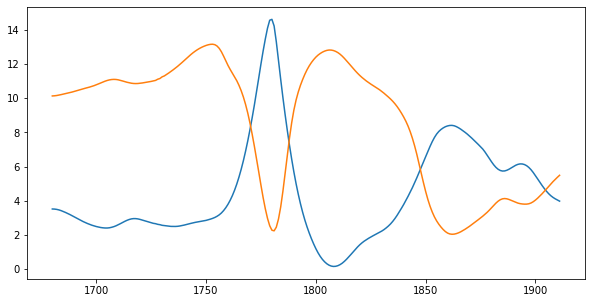

In [33]:
for session in data.SESSION_IDENTIFIER.unique():
    filteredData = data[data.SESSION_IDENTIFIER == session]
    plt.plot('FRAME', 'DISTFROMLEFT', data=filteredData, label=session)
    plt.plot('FRAME', 'DISTFROMRIGHT', data=filteredData, label=session)
    plt.plot('FRAME', 'TRACKWIDTH', data=filteredData, label=session)
    # plt.plot('WORLDPOSX', 'TRACKWIDTH', data=filteredData, label=session)
    plt.legend()

We can see that the projection onto the track at some points is being stuffed up because of some repeat values in the track data. Let's refine the points in our track.

# Initial track work 13-09

/var/folders/r4/y9yr2khx1q9d4_bz1bv0zk2w0000gn/T/ipykernel_24271/4046352292.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


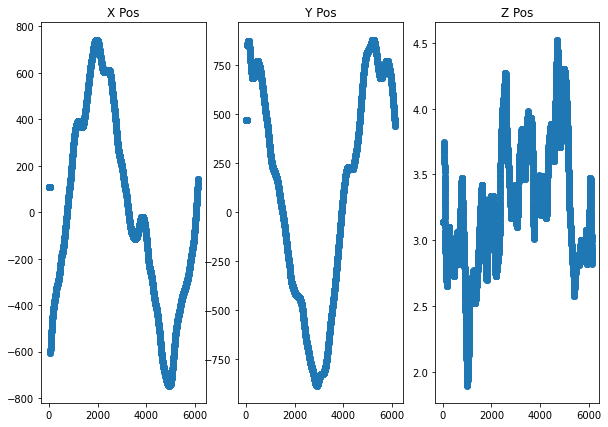

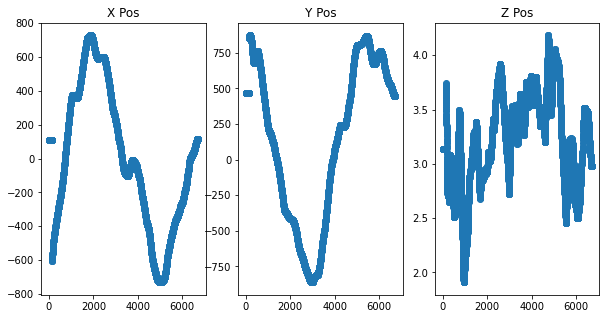

109.943344
109.943336
109.943344
109.943344
109.943344
109.943344
467.951904
467.951904
467.951904
467.951904
467.951904
467.951904
3.136822
3.136915
3.136914
3.136914
3.136914
3.136914


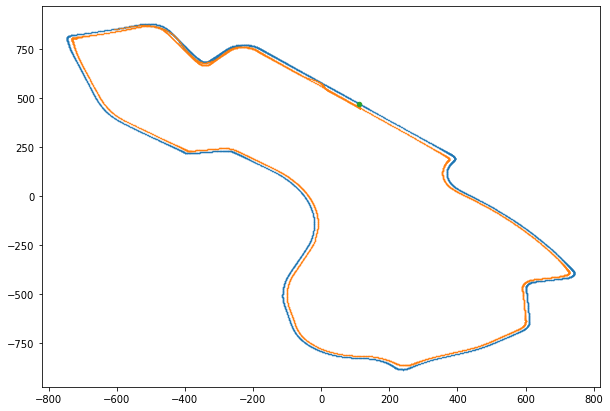

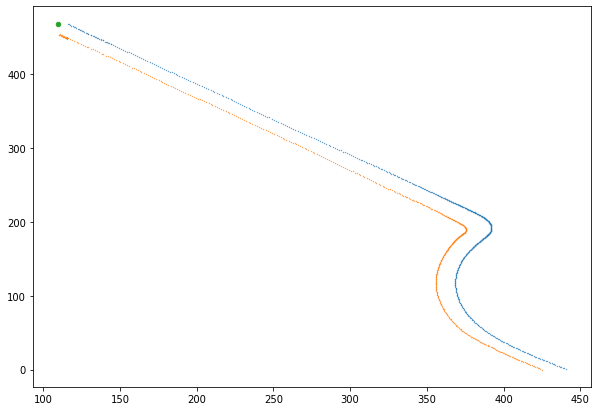

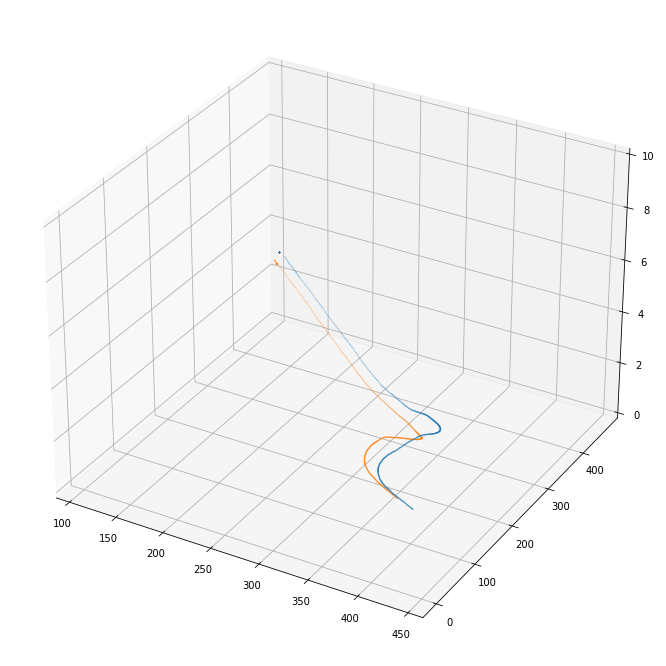

In [8]:
def loadRefData(fileSuffix):
    data = pd.read_csv(f'../localData/f1sim-ref-{fileSuffix}.csv')
    data = data.sort_values(by='FRAME').reset_index(drop=True)
    return data

left = loadRefData('left')
right = loadRefData('right')

plt.figure(figsize = (10, 7))
plt.scatter(data=left, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
plt.scatter(data=right, x='WORLDPOSX', y='WORLDPOSY', s=0.1)

'''
Finding the start point in data
'''

def posByRangeSubplot(data):   
    plt.subplot(1,3,1)
    plt.title('X Pos')
    plt.scatter(data=data, x='FRAME', y='WORLDPOSX')
    plt.subplot(1,3,2)
    plt.title('Y Pos')
    plt.scatter(data=data, x='FRAME', y='WORLDPOSY')
    plt.subplot(1,3,3)
    plt.title('Z Pos')
    plt.scatter(data=data, x='FRAME', y='WORLDPOSZ')
    plt.show()

posByRangeSubplot(left)
posByRangeSubplot(right)

print(left.head(3)['WORLDPOSX'].to_string(index=False))
print(right.head(3)['WORLDPOSX'].to_string(index=False))
print(left.head(3)['WORLDPOSY'].to_string(index=False))
print(right.head(3)['WORLDPOSY'].to_string(index=False))
print(left.head(3)['WORLDPOSZ'].to_string(index=False))
print(right.head(3)['WORLDPOSZ'].to_string(index=False))

start = pd.DataFrame(columns=['WORLDPOSX','WORLDPOSY','WORLDPOSZ'], data=np.array([[109.9433441, 467.9519043, 3.136914492]]))

plt.figure(figsize = (10, 7))
plt.scatter(data=left, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
plt.scatter(data=right, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
plt.scatter(data=start, x='WORLDPOSX', y='WORLDPOSY', s=20)

left = left[(left['WORLDPOSX'] <= 550) & (left['WORLDPOSX'] >= start['WORLDPOSX'].loc[0]) & (left['WORLDPOSY'] >= 0) & (left['WORLDPOSY'] <= start['WORLDPOSY'].loc[0])]
right = right[(right['WORLDPOSX'] <= 550) & (right['WORLDPOSX'] >= start['WORLDPOSX'].loc[0]) & (right['WORLDPOSY'] >= 0) & (right['WORLDPOSY'] <= start['WORLDPOSY'].loc[0])]

plt.figure(figsize = (10, 7))
plt.scatter(data=left, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
plt.scatter(data=right, x='WORLDPOSX', y='WORLDPOSY', s=0.1)
plt.scatter(data=start, x='WORLDPOSX', y='WORLDPOSY', s=20)

fig = plt.figure(figsize = (15, 12))
ax = fig.add_subplot(projection='3d')
ax.set(zlim=[0,10])
ax.scatter(left['WORLDPOSX'], left['WORLDPOSY'], left['WORLDPOSZ'], s=0.1)
ax.scatter(right['WORLDPOSX'], right['WORLDPOSY'], right['WORLDPOSZ'], s=0.1)
plt.show()